# Modeling Notebook

## Introduction  

The overall goal of this project is to see if I can predict both the annual and monthly sales price per bushel of grain corn (which is what people eat, as opposed to silage corn, which is what livestock eats). The annual predictions are useful for planning for the next year, whereas monthly projections help fine tune plans as the year progresses. 

In previous notebooks, the data has been scrubbed (`Data Scrubbing.ipynb`), visualized, and filtered for multicolinearity (`Data Visualization and Exploratory Analysis.ipynb`). This notebook will be used for looking at various machine learning models for predicting the target feature, `PRICE RECEIVED, MEASURED IN $ / BU`.

## Plan of Attack

1. Import Analysis Packages and Dataframes (including a data dictionary)
2. Create a helper function for quick model evaluation
3. Evaluate several regression models, including:
    - Linear
    - Ridge
    - Lasso
    - KNeighbors
    - Decision Tree
    - Random Forest
    - Support Vector
    - XGBoost
4. Create pipelines for refinement of some models
5. Create neural networks using tensorflow's `keras` package:
    - Create a helper function to quickly try different network setups.
    - Model the data using the best network.
    - Compare results to other modeling methods
6. Conclusions

## Import Analysis Packages and Dataframes

Here I will import the various packages I need for modeling and visualizing the data.

In [1]:
# Import tools and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from scipy.stats import f
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

I will now import the data from csv format as pandas dataframes.

In [2]:
# Import the filtered data as pandas dataframes.
annual_df_model_ready = pd.read_csv('./Dataframes/annual_df_model_ready.csv', index_col=0)
monthly_df_model_ready = pd.read_csv('./Dataframes/monthly_df_model_ready.csv', index_col=0, infer_datetime_format=True)

# Check that the dataframes were imported correctly.
display(annual_df_model_ready, monthly_df_model_ready)

,Cooling Degree Days,GDP_PCH,USPop,baseline,"PRICE RECEIVED, MEASURED IN $ / BU"
Year,,,,,
1950,1080,10.03834,152270000,1.520000,1.52
1951,1168,15.70438,154880000,1.520000,1.66
1952,1272,5.88836,157550000,1.590000,1.52
1953,1276,5.95544,160180000,1.566667,1.48
1954,1275,0.34210,163030000,1.553333,1.43
...,...,...,...,...,...
2016,1528,2.68638,322940000,3.923333,3.36
2017,1390,4.19638,324990000,3.556667,3.36
2018,1547,5.37760,326690000,3.443333,3.61


,Cooling Degree Days,Precipitation,GDP_PCH,USPop,baseline,"PRICE RECEIVED, MEASURED IN $ / BU"
1950-01-01,23,3.36,1.256463,1.498775e+08,1.150000,1.15
1950-02-01,11,2.23,1.256463,1.500950e+08,1.150000,1.16
1950-03-01,12,2.49,1.256463,1.503125e+08,1.150000,1.19
1950-04-01,21,2.08,1.134147,1.505300e+08,1.150000,1.26
1950-05-01,106,2.88,1.134147,1.507475e+08,1.155000,1.34
...,...,...,...,...,...,...
2020-08-01,351,2.43,2.842827,3.293333e+08,3.541667,3.12
2020-09-01,174,2.44,2.842827,3.294700e+08,3.534167,3.41
2020-10-01,77,2.18,0.534603,3.296067e+08,3.526389,3.61
2020-11-01,28,1.94,0.534603,3.297433e+08,3.522222,3.79


The dataframes appear to have been imported correctly. There are 71 rows and 5 features for the annual dataframe, including the target feature. And for the monthly dataframe, there are 852 rows and 6 features, including the target as expected.

#### Dictionary for Annual Data

- `PRICE RECEIVED, MEASURED IN $ / BU`: the average price received for a bushel of grain corn.
- `Cooling Degree Days`: a measure of how many degrees and how many days the temperature is above room temperature.
- `GDP_PCH`: change in US GDP versus the previous year.
- `USPop`: total US population in the given year.
- `baseline`: (***baseline value***) the average price received in the previous 3 year.

#### Dictionary for Monthly Data
 
- `PRICE RECEIVED, MEASURED IN $ / BU`: (***target***) the average price received for a bushel of grain corn.
- `Precipitation`: total rainfall in inches, averaged across all 50 states for the given month.
- `Cooling Degree Days`: a measure of how many degrees and how many days the temperature is above room temperature.
- `USPop`: total US population in a given month (modeled from yearly US population).
- `GDP_PCH`: change in US GDP for each month (calculated by dividing the quarterly GDP_PCH by three).
- `baseline`: (***baseline value***) the price received the previous month.

## Helper Function for Model Evaluation

Here, I will define a helper function (along with some miscellany to help the function work) that will let me quickly compare different machine learning models using similar metrics. This function will take in the model of interest and apply it to the annual and monthly data, which it will split into train and test sets. The function will also allow for the use of a scaler function for models that strongly depend on the scale of the data as well as key word arguments for the models themselves. The function returns a tuple containing the two models in case I want to get any metadata out of them. Additionally, the function prints out model performance metrics, including the model's predicted values for the `PRICE RECEIVED, MEASURED IN $ / BU` plotted as a function of the true values for this feature, plots of the baseline prediction values vs the true values, plots of the model residuals, and a report containing the p-values obtained from F-tests comparing whether or not the model resulted in a statistically significant reduction in error compared to the baseline value.  

For the F-test, the null and alternate hypotheses are:
- H<sub>0</sub> (*null hypothesis*): there <u>is **no** difference</u> in the model's performance and the baseline performance.  
- H<sub>1</sub> (*alternative hypothesis*): there <u>is **a** difference</u> between the model performance and the baseline performance.

For this test, my $ \alpha $ = 0.05. Therefore, if my p-value is less than  $ \alpha $, I can reject the null hypothesis and assume the model accuracy was significantly different than the baseline accuracy. However, if the p-value is above  $ \alpha $, I must fail to reject the null hypothesis and assume the model performed approximately the same as the baseline.

In [3]:
# Create a list of titles for true vs predicted plots. 
list_of_titles =[
    "Annual " + "\u0332".join("Model") + " Data", 
    "Monthly " + "\u0332".join("Model") + " Data", 
    "Annual " + "\u0332".join("Baseline") + " Data", 
    "Monthly " + "\u0332".join("Baseline") + " Data"
]

# Create a list of names to be used for both residual and error plots.
names = ['Annual Data', 'Monthly Data']

# Define a function to calculate the F-test p-value.
def f_test_p_value(list1, list2):
    """
    This function takes two lists, calculates the standard deviations of the two lists, and then compares
    those standard deviations using an F-test. The function then returns the p-value from the F-test.
    
    Args:
        list1 (list): a list of floats.
        list2 (list): a list of floats.
        
    Returns:
        p-value (float): p-value calculated for the f-test
    """
    
    # Find the F-test numerator and denominator. The numerator is the larger standard deviation.
    # The denominator is the smaller standard deviation.
    numerator = max(np.var(list1), np.var(list2))
    denominator = min(np.var(list1), np.var(list2))
    
    # Check to see if the denominator is equal to zero.
    # If it is, return a p-value of 0.
    if denominator == 0:
        return 0
    
    # Calculate the degrees of freedom for the F-test.
    # Here, the two lists are always the same length, so the degrees of freedom will also be the same.
    dof = len(list1) - 1
    
    # Calculate the F-value.
    F_value = numerator/denominator
    
    # Get the p-value.
    p_value = 1 - f.cdf(F_value, dof, dof)
    
    # Return the p-value.
    return p_value

# Define a function for assessing model performance and printing a report.
def model_fitter_plotter(model, ranges = [0.5,8], shuffle=True, scaler='none', full_report=True, **kwargs):
    """
    Evaluates a model for predicting the sales price per bushel of corn for both the annual and monthly dataframes, 
    resulting in a printed report. This report contains including a plot of the model's predicted values vs the true values,
    plots of the baseline prediction values vs the true values, plots of the model residuals, and plots of the model error 
    vs the baseline error, along with the p-value obtained from an F-test comparing whether or not the model resulted in a 
    statistically significant reduction in error compared to the baseline value.
    
    Args:
        model (function): the function name for the model of interest.
        ranges (list of numbers, optional): two numbers controlling the plot axes dimensions. Defualt = [0.5,8]
        shuffle (bool, optional): controls whether the train_test_split function shuffles the data or not. 
            Default=True shuffles the data.
        scaler (function, optional): if a scaler function is provided, the data is scaled prior to analysis. 
            Default = 'none', no scaler is applied.
        full_report (bool, optional): if set to False, the report is truncate to just show the first two
            plots. Default = True, the full report is printed.
        
    **kwargs:
        All keyword functions are passed to the model as model arguements.
        
    Returns:
        (model_an, model_mn): a tuple containing the two models constructed by the function.
    """
    
    # Split the annual and monthly data into train and test sets. All splits are performed using random_state=1.
    # Note: This is done within the function incase shuffle is set to False.
    X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(
        annual_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
        annual_df_model_ready['PRICE RECEIVED, MEASURED IN $ / BU'], 
        shuffle=shuffle, 
        test_size=0.2,
        random_state=1
    )
    X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
        monthly_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
        monthly_df_model_ready['PRICE RECEIVED, MEASURED IN $ / BU'], 
        shuffle=shuffle, 
        test_size=0.2,
        random_state=1
    )
    
    # Create models for both the annual (an) and monthly (mn) data, passing the model any provided key word arguements.
    model_an = model(**kwargs)
    model_mn = model(**kwargs)
    
    # Check if a scaler function was provided. If so, scale the X data.
    if scaler == 'none':
        x_tr_a = X_train_annual
        x_te_a = X_test_annual
        x_tr_m = X_train_monthly
        x_te_m = X_test_monthly
        
    else:
        keys_a = X_train_annual.keys()
        scaler_a = scaler()
        scaler_a.fit(X_train_annual)
        x_tr_a = scaler_a.transform(X_train_annual)
        x_tr_a = pd.DataFrame(x_tr_a, columns=keys_a)
        x_te_a = scaler_a.transform(X_test_annual)
        x_te_a = pd.DataFrame(x_te_a, columns=keys_a)
        
        keys_m = X_train_monthly.keys()
        scaler_m = scaler()
        scaler_m.fit(X_train_monthly)
        x_tr_m = scaler_m.transform(X_train_monthly)
        x_tr_m = pd.DataFrame(x_tr_m, columns=keys_m)
        x_te_m = scaler_m.transform(X_test_monthly)
        x_te_m = pd.DataFrame(x_te_m, columns=keys_m)

    # Fit the models to the annual and monthly train data, respectively.
    model_an.fit(x_tr_a, y_train_annual)
    model_mn.fit(x_tr_m, y_train_monthly)

    # Predict y values for the train and test data for both the annual and monthly data.
    y_train_pred_an = model_an.predict(x_tr_a)
    y_train_pred_mn = model_mn.predict(x_tr_m)

    y_test_pred_an = model_an.predict(x_te_a)
    y_test_pred_mn = model_mn.predict(x_te_m)
    
    # Check if full_report is True.
    if full_report:
        # If so, give the plot two rows.
        rows = 2
            
    else:
        # Else, give the plot 1 row.
        rows = 1
    
    # Create subplots for the predicted vs true plots.
    plt.subplots(rows*2, figsize=(9,4.5*rows))
    
    # Create empty lists to hold the % errors and residuals resulting from the model.
    errors = []
    residuals = []
    
    # Create a list of features to compare.
    list_of_tuples = [
        (y_train_annual, y_train_pred_an, y_test_annual, y_test_pred_an), 
        (y_train_monthly, y_train_pred_mn, y_test_monthly, y_test_pred_mn), 
        (y_train_annual, X_train_annual['baseline'], y_test_annual, X_test_annual['baseline']), 
        (y_train_monthly, X_train_monthly['baseline'], y_test_monthly, X_test_monthly['baseline'])
    ]
    
    # Check if full_report is false.
    if not full_report:
        
        # If so, remove the last two tuples from list_of_tuples
        list_of_tuples.pop()
        list_of_tuples.pop()
    
    # Iterate through the features to compare.
    for i, tup in enumerate(list_of_tuples):
        
        # Calculate the % errors and residuals for the different feature pairs.
        errors.append(1 - tup[1]/tup[0])
        errors.append(1 - tup[3]/tup[2])
        
        residuals.append(tup[1] - tup[0])
        residuals.append(tup[3] - tup[2])
        
        # Plot the true vs predicted values, including the train and test data.
        plt.subplot(rows,2, i+1)

        m1, b1, r1, p1, std_err1 = linregress(tup[0], tup[1])
        plt.scatter(tup[0], tup[1], label=f"Train R\u00b2: {round(r1**2, 3):.3f}", color='blue')
        m2, b2, r2, p2, std_err2 = linregress(tup[2], tup[3])
        plt.scatter(tup[2], tup[3], label=f"Test R\u00b2: {round(r2**2, 3):.3f}", color='orange')
        plt.plot(ranges, ranges, color='DarkSlateGray', ls='--')
        plt.legend(fontsize=14, framealpha=0.5)
        plt.xlim(ranges[0], ranges[1])
        plt.ylim(ranges[0], ranges[1])
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xlabel('True Values', size=14)
        plt.ylabel('Predicted Values', size=14)
        plt.title(list_of_titles[i], size=16)
        
    plt.suptitle("\u0332".join(model.__name__), size=18)
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    # Check if full_report is false.
    if not full_report:
        # If so, close the function.
        return 'end of truncated report'
    
    # Create the residual plots.
    plt.subplots(2, figsize=(9,4.5))
    
    for i, tup in enumerate(list_of_tuples[0:2]):
        plt.subplot(1,2,1+i)
        plt.scatter(tup[0], residuals[i*2], color='blue', label='train')
        plt.scatter(tup[2], residuals[i*2+1], color='orange', label='test')
        plt.plot(ranges, [0,0], ls='--', color='DarkSlateGray')
        plt.xlim(ranges[0], ranges[1])
        plt.ylabel('Residuals', size=14)
        plt.xlabel('True Sales Price', size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.title(names[i], size=18)
        plt.legend(fontsize=14, framealpha=0.5)
        
    plt.suptitle("\u0332".join("Residual Plots"), size=18)
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    # Generate a report of performance.
    print(f"Model: \033[1m {model.__name__} \033[0m")
    
    # Iterate through the annual and monthly data.
    for sub, i in enumerate(range(0,4,2)):
        print
        # Calculate the p-value for the annual and monthly data.
        train_p = f_test_p_value(errors[i], errors[i+4])
        test_p = f_test_p_value(errors[i+1], errors[i+5])
        
        # Print report.
        print(f"{names[sub].split()[0]} Train Data, p: {round(train_p,3):.2e}")
        print("Statistically different than the baseline.\n" if train_p <= 0.05 else "Not statistically different from the baseline.\n")
        print(f"{names[sub].split()[0]} Test Data, p: {round(test_p,3):.2e}")
        print("Statistically different than the baseline.\n" if test_p <= 0.05 else "Not statistically different from the baseline.\n")
    return (model_an, model_mn)

## Model Testing

### Linear Regression  

Linear regression is one of the most basic modeling techniques. Here, we are simply looking for linear relationships between our target feature (`PRICE RECEIVED, MEASURED IN $ / BU`) and the independent features. Since there are multiple independent features for both the annual and monthly data, this is actually a multiple linear regression model.  

Before running the helper function, though, it will likely be helpful for me to talk about what the report will tell me. First, 4 plots will be printed out in a section named after the function passed in. The top left and right plots will show the model's predicted values as a function of the true values for both the train (blue) and test (orange) values. The dashed line in these plots is a 1:1 correlation between the axes. The goal is to get all of the data to fall on this line. Additionally, R<sup>2</sup> values will be provided indicating how well the predicted values match the true values. An R<sup>2</sup> = 1 means the model performed perfectly, and an R<sup>2</sup> = 0 means the model failed entirely. Below these two plots are similar plots for the baseline data.

After the section named after the model function is the *Residual Plots* section. Here, the residuals resulting from the model are plotted as a function of the true values. Ideally, there will be no observable patterns in this data. An ideal model evenly and randomly distributes any error among the various data.

Last, a report is printed out with the p-values resulting from F-tests of the predicted value errors compared to the baseline value errors. If the p-value is less than 0.05, the report indicates a statistical difference between the scatter of the model error compared to the scatter in the baseline error.

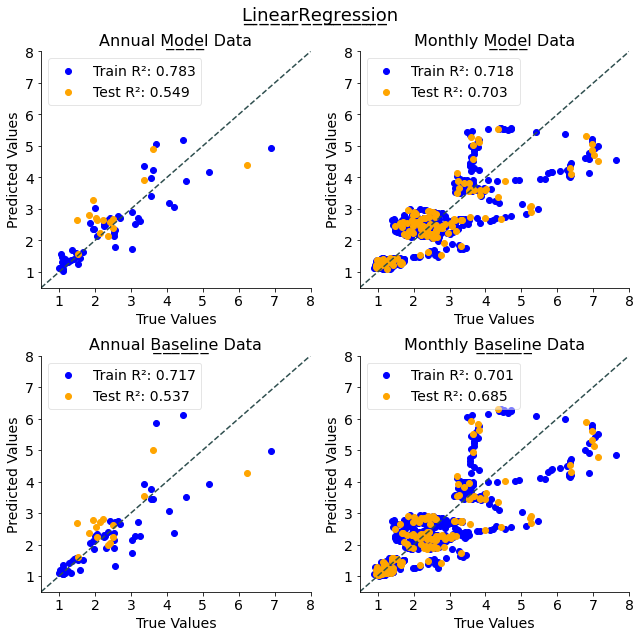

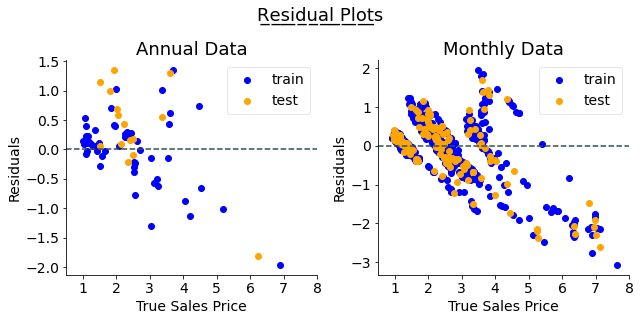

Model:  LinearRegression 
Annual Train Data, p: 4.18e-01
Not statistically different from the baseline.

Annual Test Data, p: 4.39e-01
Not statistically different from the baseline.

Monthly Train Data, p: 3.30e-01
Not statistically different from the baseline.

Monthly Test Data, p: 3.75e-01
Not statistically different from the baseline.



In [4]:
# Use the helper function to evaluate a linear regression model. This model takes no hyper parameters. 
# Unpack the model tuple for further access.
lin_annual, lin_monthly = model_fitter_plotter(LinearRegression, shuffle=True)

The plots of the model data vs the true values (top panels) look fairly similar to the baseline data, found below the top panels. There is a slight improvement in the R<sup>2</sup> values for the model over the baseline R<sup>2</sup> values. For example, the test R<sup>2</sup> values for the monthly data are 0.703 for the model and 0.685 for the baseline. This may seem like the model is doing better than the baseline. However, with the number of samples in each dataframe, I am dealing with fairly limited statistics. That is why the p-value must be calculated to determine if the %error resulting from the model is statistically smaller than that produced by the baseline. In this case, the smallest p-value was only about 0.332, which is well above $ \alpha $=0.05. Thus, I can't confidently say this model does any better than the baseline at predicting the corn prices.  

Additionally, the residual plots don't look very randomly distributed, especially for the monthly data. This is likely because there is such severe variability in the data to begin with. Thus, the model doesn't do a great job of unbiasedly modeling the data.

What this model lacks in predictive power, however, it makes up for in interpretability. I can now look at the coefficients from this model in order to determine what features the linear regression model determined were most important.

In [5]:
# Here I am getting the feature names and coefficients. I am then zipping them together, turning the resulting zip
# object into a list, and printing it out. I am doing this for both the annual and monthly models.
print(
    list(
        zip(
            annual_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU').keys(),
            np.round(lin_annual.coef_,5)
        )
    )
)

print('\n')

print(
    list(
        zip(
            monthly_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU').keys(), 
            np.round(lin_monthly.coef_, 5)
        )
    )
)

[('Cooling Degree Days', 0.00212), ('GDP_PCH', 0.03339), ('USPop', 0.0), ('baseline', 0.61742)]


[('Cooling Degree Days', 0.00016), ('Precipitation', -0.00324), ('GDP_PCH', 0.04455), ('USPop', 0.0), ('baseline', 0.71767)]


Interesting. In both the annual and monthly data, the major feature used was the baseline itself. This explains why the model results looked so similar to the baseline results in the report. In both models, the US population had a coefficient of 0. This is surprising to me, as I expected this feature to play a major role here. All of the other features contributed to the model to much smaller amounts, and precipitation even showed a negative correlation with corn bushel prices.  

Linear regression doesn't really have any hyperparameters to optimize, so I won't be including it in my pipeline later on. But, hopefully, I can come up with a model that does a little bit better.

Talk about coefficients, residual diagnostics, hyperparameters.

### Ridge Regression

Up next, I am going to be looking at Ridge regression. This form of regression is fairly similar to linear regression, except it aims to reduce the values of the coefficients in order to reduce complexity of the model. It does this by adding the squared value of the coefficients to the models loss term, which the model uses to evaluate how good the fit is. This type of coefficient suppression is known as l2 regularization.  

I'm not expecting this model to do much better than simple linear regression, but there was some multicolinearity between the baseline and US population data, as seen in the `Data Visualization and Exploratory Analysis.ipynb` notebook. So, ridge regression may perform slightly better.  

Ridge regression with an alpha of 1 is essentially a linear regression model. I'm going to give the model an alpha term of 10. This should result in a stronger regularization than was used for the linear model.

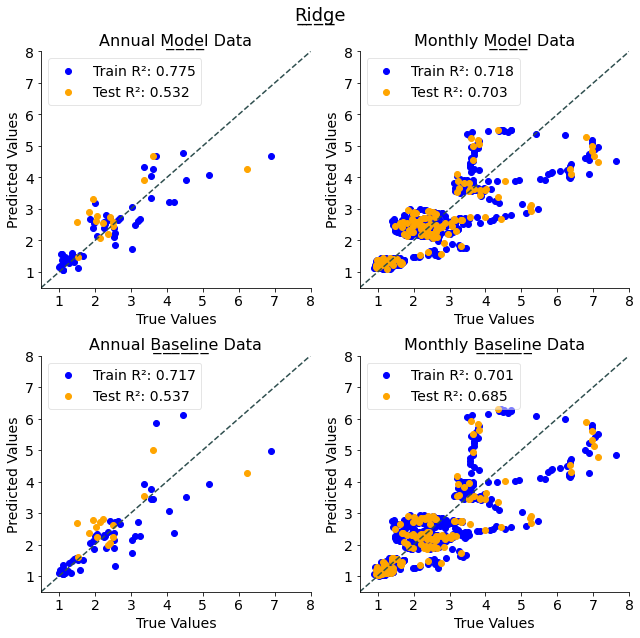

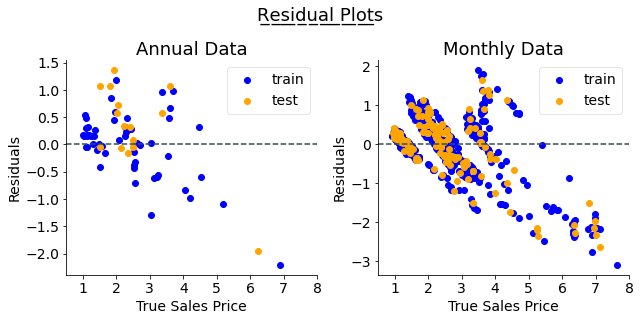

Model:  Ridge 
Annual Train Data, p: 2.30e-01
Not statistically different from the baseline.

Annual Test Data, p: 4.20e-01
Not statistically different from the baseline.

Monthly Train Data, p: 3.72e-01
Not statistically different from the baseline.

Monthly Test Data, p: 3.90e-01
Not statistically different from the baseline.



In [6]:
# Use the helper function to evaluate a linear regression model. This model takes no hyper parameters. 
# Unpack the model tuple for further access.
ridge_annual, ridge_monthly = model_fitter_plotter(Ridge, alpha=10)

Hmm... That didn't seem to improve things much compared to the linear regression model. I won't go through interpreting all of the results since they are so similar to the linear results, other than to say the R<sup>2</sup> values are slightly lower and the p-values are slightly higher.  

There are a few hyperparameters I can try to optimize, such as varying `alpha`, playing around with the precision value (`tol`), and varying the solver function used in the model. I will take a quick look to see if varying the alpha value improves my R<sup>2</sup> values at all. For this, I will just look at the monthly data.

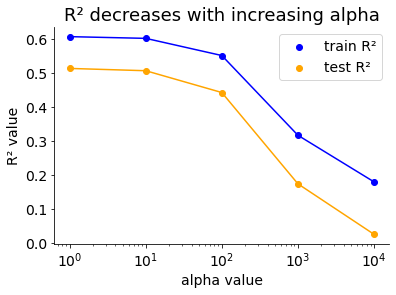

In [7]:
# Split the data into train and test sets.
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    monthly_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
    monthly_df_model_ready['PRICE RECEIVED, MEASURED IN $ / BU'], 
    test_size=0.2,
    random_state=1
)

# Create a list of values to test.
alpha_values = [1,10,100,1000,10000]

# Create lists for storing R2 values.
train_r2_values = []
test_r2_values = []

# Iterate over the lists of values to test.
for i in alpha_values:
    
    # Instantiate the model.
    model = Ridge(alpha = i)
    
    # Fit the model with the training data.
    model.fit(X_train_monthly, y_train_monthly)
    
    # Predict y values for the the train and test data.
    y_pred_train = model.predict(X_train_monthly)
    y_pred_test = model.predict(X_test_monthly)
    
    # Calculate R2 values and append them to the appropriate lists.
    train_r2_value = r2_score(y_pred_train, y_train_monthly) 
    train_r2_values.append(train_r2_value)
    test_r2_value = r2_score(y_pred_test, y_test_monthly)
    test_r2_values.append(test_r2_value)

# Plot the R2 values vs the hyperparameters.
plt.scatter(alpha_values, train_r2_values, label='train R\u00b2', c='blue')
plt.plot(alpha_values, train_r2_values, c='blue')
plt.scatter(alpha_values, test_r2_values, label='test R\u00b2', c='orange')
plt.plot(alpha_values, test_r2_values, c='orange')
plt.legend(fontsize=14)
plt.xlabel('alpha value', size=14)
plt.ylabel('R\u00b2 value', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('R\u00b2 decreases with increasing alpha', size=18)
plt.xscale('log')
sns.despine()
plt.show()

It doesn't look like increasing alpha helped. In fact, it seems to have hurt quite a bit. I won't be including Ridge regression in my pipeline, but some hyperparameters I could optimize include:
- `alpha`
- `tol`: a precision metric
- The solver function used in the model:
    - `auto`: tries to choose the best function
    - `svd`: singular value decomposition
    - `lsqr`: least squares fitting
    - `saga`: unbiased stochastic average gradient  

However, with such poor performance, I will likely get better results using more complicated models.

I'll take a quick peak under the hood at the model coefficients before moving on to Lasso regression.

In [8]:
# Here I am getting the feature names and coefficients. I am then zipping them together, turning the resulting zip
# object into a list, and printing it out. I am doing this for both the annual and monthly models.
print(list(zip(annual_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU').keys(), np.round(ridge_annual.coef_,5))))

print('\n')

print(list(zip(monthly_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU').keys(), np.round(ridge_monthly.coef_, 5))))

[('Cooling Degree Days', 0.00213), ('GDP_PCH', 0.0321), ('USPop', 0.0), ('baseline', 0.45386)]


[('Cooling Degree Days', 0.00016), ('Precipitation', -0.00303), ('GDP_PCH', 0.04126), ('USPop', 0.0), ('baseline', 0.69742)]


These coefficients are fairly similar to those obtained for the linear regression model. Baseline is still the primary feature, with US population again not contributing.

### Lasso Regression

Lasso regression is similar to ridge regression, accept it uses l1 regularization instead of l2. In l1 regularization, the absolute value of the coefficients are added to the models loss term. What this means is that while ridge regularization tries to minimize the coefficients, lasso regression can actually take them all the way to zero.  

I'm again not expecting huge improvements over the linear and ridge regression models, but let's give it a go. Lasso also requires an alpha term, like ridge regression, except here an alpha of 0 is the same as linear regression. I will be using an alpha term of 1. 

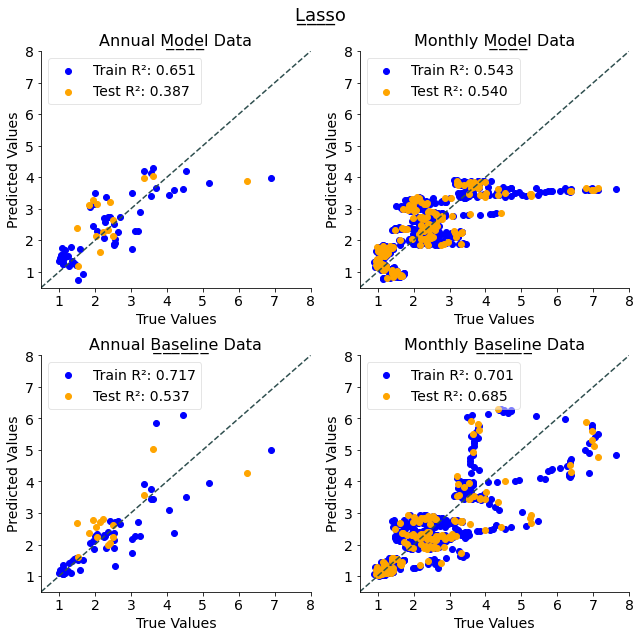

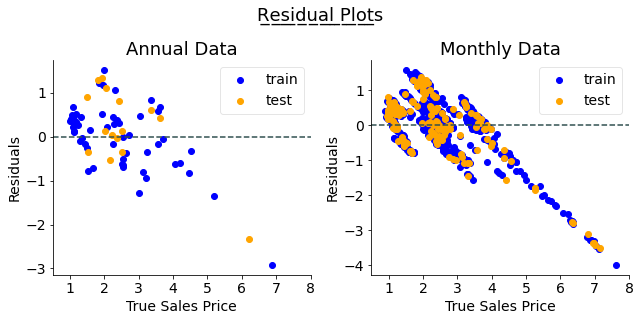

Model:  Lasso 
Annual Train Data, p: 1.00e-03
Statistically different than the baseline.

Annual Test Data, p: 2.18e-01
Not statistically different from the baseline.

Monthly Train Data, p: 0.00e+00
Statistically different than the baseline.

Monthly Test Data, p: 0.00e+00
Statistically different than the baseline.



In [9]:
annual_Lasso, monthly_Lasso = model_fitter_plotter(Lasso, alpha=1)

Woe! l1 regularization is not a friend to this data. The R<sup>2</sup> values all dropped significantly compared to the ridge and linear regression models. Though, the residuals plot for the monthly data does kind of remind me of the logo from Final Fantasy vii.

<img src="./Data/meteor.jpg" alt="Final Fantasy vii logo">  

I got 3 p-values for this data that show a statistical difference between the model performance and the baseline data. This may seem exciting, but in this case rejecting the null hypothesis means that the baseline performed significantly better than the model. The ax swings both ways...

I'll quickly play around with this model's alpha value to see how changing it affects my R<sup>2</sup> values.

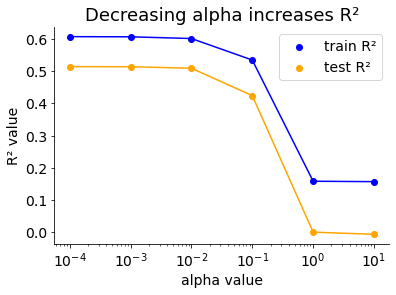

In [10]:
# Split the data into train and test sets.
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    monthly_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
    monthly_df_model_ready['PRICE RECEIVED, MEASURED IN $ / BU'], 
    test_size=0.2,
    random_state=1
)

# Create a list of values to test.
alpha_values = [0.0001, 0.001,0.01,0.1,1,10]

# Create lists for storing R2 values.
train_r2_values = []
test_r2_values = []

# Iterate over the lists of values to test.
for i in alpha_values:
    
    # Instantiate the model.
    model = Lasso(alpha = i)
    
    # Fit the model with the training data.
    model.fit(X_train_monthly, y_train_monthly)
    
    # Predict y values for the the train and test data.
    y_pred_train = model.predict(X_train_monthly)
    y_pred_test = model.predict(X_test_monthly)
    
    # Calculate R2 values and append them to the appropriate lists.
    train_r2_value = r2_score(y_pred_train, y_train_monthly) 
    train_r2_values.append(train_r2_value)
    test_r2_value = r2_score(y_pred_test, y_test_monthly)
    test_r2_values.append(test_r2_value)

# Plot the R2 values vs the hyperparameters.
plt.scatter(alpha_values, train_r2_values, label='train R\u00b2', c='blue')
plt.plot(alpha_values, train_r2_values, c='blue')
plt.scatter(alpha_values, test_r2_values, label='test R\u00b2', c='orange')
plt.plot(alpha_values, test_r2_values, c='orange')
plt.legend(fontsize=14)
plt.xlabel('alpha value', size=14)
plt.ylabel('R\u00b2 value', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Decreasing alpha increases R\u00b2', size=18)
plt.xscale('log')
sns.despine()
plt.show()

It looks like the best R<sup>2</sup> values are obtained with an alpha value of about 0.001. Below this, the l1 regularization does not seem to improve the model much. With an alpha of 1 or greater, the R<sup>2</sup> value drops dramatically, likely as a result of over regularization. 

Lasso regression also didn't work very well. I could try optimizing some hyperparameters, such as `alpha` or the precision metric `tol`. However, I'm not expecting this model to somehow magically become the best when it's already performing so poorly. This model would be more useful if I hadn't already screened for multicolinearity.

### KNeighbors Regression

I was a bit careful in defining the goal of this project by saying I want to predict sales prices. An important word was intentionally left out of that statement. The word is <u>future</u>. I am not actually trying to predict future prices because then I would need to use an extrapolation model, whereas most machine learning models are really only useful for interpolation. Extrapolation is when you try to predict values that are outside of the range of your training data. An example extrapolation problem could be something like "What will the population be in 20 years?" There are models that can handle this, such as a linear fit to the data or fitting with some other continuous function. However, most of the more complex machine learning models are really only good at interpolation. 

To show why this distinction is important, I will try to run the KNeighbors regression model by fitting the model with the data from 1950 to 2006 and try to predict the values from 2007 to 2020, where the sales prices are generally higher. The way KNeighbors regression works is by calculating the distance of an observation's X values to all of the X values of the training set. Then, the "k" nearest points are selected and the average of the y values of these nearest points is returned as the predicted value for the observation.

Let's see what happens when I try to use KNeighbors regression to predict future prices.

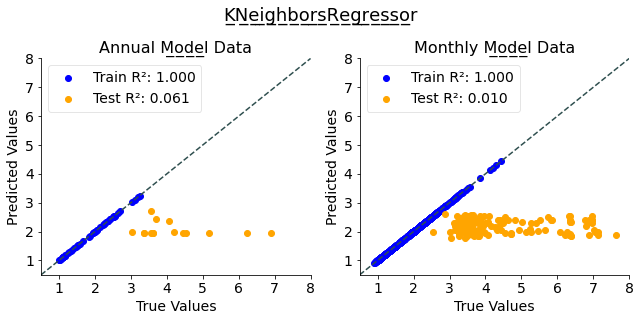

'end of truncated report'

In [11]:
model_fitter_plotter(KNeighborsRegressor, scaler=StandardScaler, full_report=False, shuffle=False, n_neighbors=1)

Notice that the model fit all of the training data perfectly well. However, it did a horrible job with the test data. Why is this? Well, for each training datum, the nearest point was itself. Therefore, each datum in the training set was predicted to be itself. For much of the test data, however, the y values were outside of the trained range and could not be predicted well at all. So, the predicted values were just set equal to the nearest trained value.  

There are ways of turning an extrapolation problem into an interpolation problem by doing things like flattening the data by dividing by some time dependent function. This can get the majority of future values into the training range. This approach would also require flattening most of the independent features as well. However, it can be quite difficult to come up with an appropriate flattening function, especially when the thing you are trying to predict can experience dramatic fluctuations. Therefore, here I am simply cheating a little and shuffling the data.  

Let me try KNeighbors regression again with a shuffled data set. 

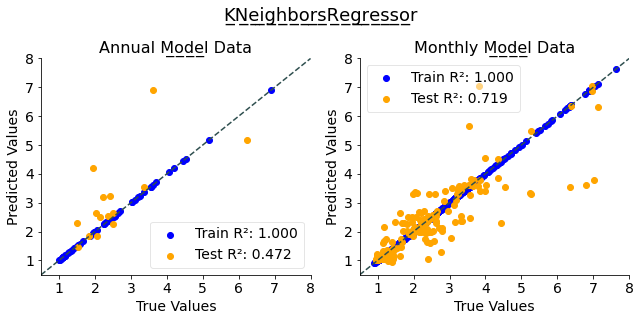

'end of truncated report'

In [12]:
model_fitter_plotter(KNeighborsRegressor, scaler=StandardScaler, full_report=False, n_neighbors=1)

Notice that the model did a lot better this time. I got R<sup>2</sup> values of 0.472 and 0.719 for the annual and monthly data, respectively. But why are these values so much lower than the R<sup>2</sup>=1 for the training data? This is an example of model over fitting. The model thinks to much about the specifics of the training data and not enough about the general trends. There are a few things I can do to fix this, such as increasing the number of neighbors, "k", for each data point to be compared to. Next, I will try using 3 neighbors.

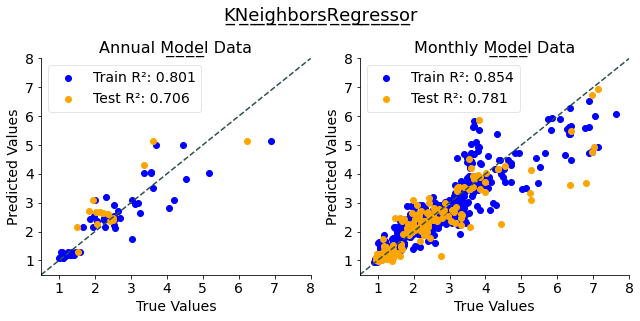

'end of truncated report'

In [13]:
model_fitter_plotter(KNeighborsRegressor, scaler=StandardScaler, full_report=False, n_neighbors=3)

Notice when I use 3 nearest neighbors, the R<sup>2</sup> values increased from 0.472 to 0.668 for the annual data and from 0.719 to 0.757 for the monthly data. I will now take a look at how the number k affects my R<sup>2</sup> values over a range of k=1 to 15. To simplify this analysis, I will again just look at the monthly data. In my later pipeline, I will optimize for both the annual and monthly data.

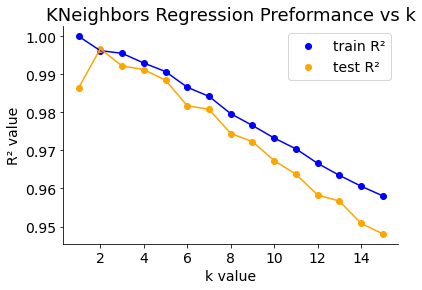

In [14]:
# Split the data into train and test sets.
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    monthly_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
    monthly_df_model_ready['PRICE RECEIVED, MEASURED IN $ / BU'], 
    test_size=0.2,
    random_state=1
)

# Create a list of values to test.
k_values = np.arange(1,16)

# Create lists for storing R2 values.
train_r2_values = []
test_r2_values = []

# Iterate over the lists of values to test.
for i in k_values:
    
    # Instantiate the model.
    model = KNeighborsRegressor(n_neighbors = i)
    
    # Fit the model with the training data.
    model.fit(X_train_monthly, y_train_monthly)
    
    # Predict y values for the the train and test data.
    y_pred_train = model.predict(X_train_monthly)
    y_pred_test = model.predict(X_test_monthly)
    
    # Calculate R2 values and append them to the appropriate lists.
    train_r2_value = r2_score(y_pred_train, y_train_monthly) 
    train_r2_values.append(train_r2_value)
    test_r2_value = r2_score(y_pred_test, y_test_monthly)
    test_r2_values.append(test_r2_value)

# Plot the R2 values vs the hyperparameters.
plt.scatter(k_values, train_r2_values, label='train R\u00b2', c='blue')
plt.plot(k_values, train_r2_values, c='blue')
plt.scatter(k_values, test_r2_values, label='test R\u00b2', c='orange')
plt.plot(k_values, test_r2_values, c='orange')
plt.legend(fontsize=14)
plt.xlabel('k value', size=14)
plt.ylabel('R\u00b2 value', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('KNeighbors Regression Preformance vs k', size=18)

sns.despine()
plt.show()

It looks like the best score is obtained for the monthly data with k=2. Notice that the r<sup>2</sup> value of the training data drops slightly when k=2, compared to k=1. This is fine, because we aren't trying to optimize our prediction for the training data, we already know what the training data says. It is the test data we really care about. I will now print out a full report using k=2.

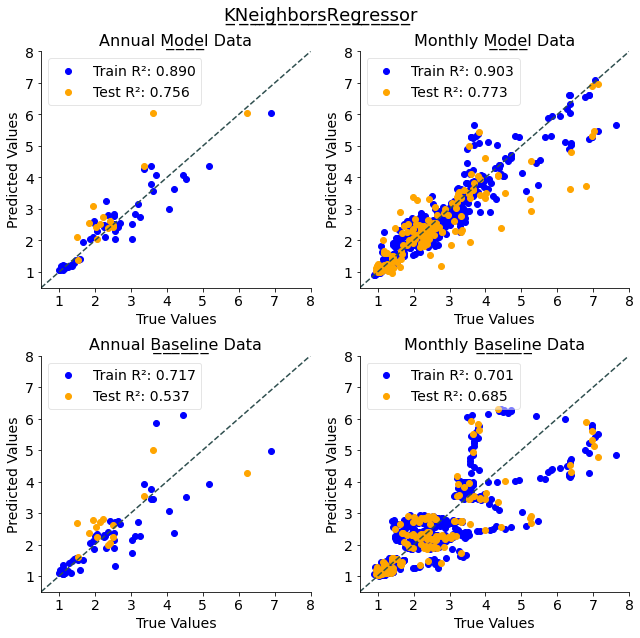

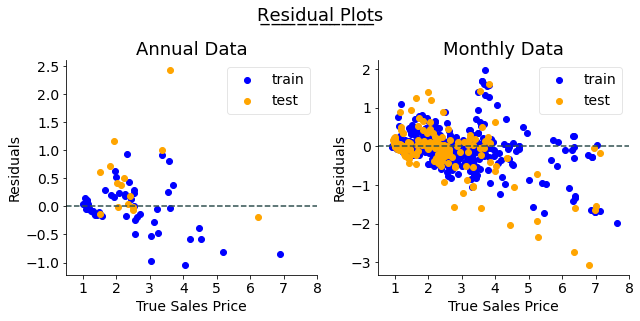

Model:  KNeighborsRegressor 
Annual Train Data, p: 1.20e-02
Statistically different than the baseline.

Annual Test Data, p: 2.67e-01
Not statistically different from the baseline.

Monthly Train Data, p: 0.00e+00
Statistically different than the baseline.

Monthly Test Data, p: 1.93e-01
Not statistically different from the baseline.



(KNeighborsRegressor(n_neighbors=2), KNeighborsRegressor(n_neighbors=2))

In [15]:
model_fitter_plotter(KNeighborsRegressor, scaler=StandardScaler, n_neighbors=2)

I clearly get better R<sup>2</sup> values for the model data (0.756 and 0.773 for the annual and monthly test data, respectively) than for the baseline data (0.537 and 0.685 for the annual and monthly data, respectively). Additionally, there seems to be much less of a noticeable pattern in the residual plots, especially for the monthly data. However, when comparing the residuals for these models, the KNeighbors regression model is still not resulting in a statistically significant improvement for the test data.  

Features I will try to optimize for this model include:
- `n_neighbors`: the k value
- `weights`: `uniform` and `distance`. This parameter controls whether all neighbors are weighted equally or if closer neighbors are given more weight in calculating the average. 
- `algorithm`: `ball_tree`, `kd_tree`, and `brute`. These are different methods for mapping the data spatially.

### Decision Tree Regression with DecisionTreeRegressor

Decision tree regression is somewhat similar to KNeighbors regression in that data predictions are controlled by other near data. The main difference is how this is done. In decision trees, the data is iteratively separated into different groups using decision boundaries (such as a median value of an independent feature) until all of the data is in its own group. The test data is then put through the same decision model to make predictions. 

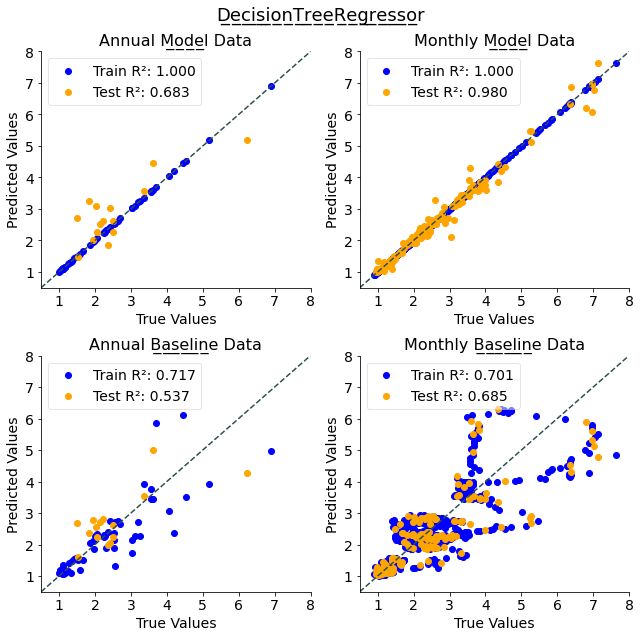

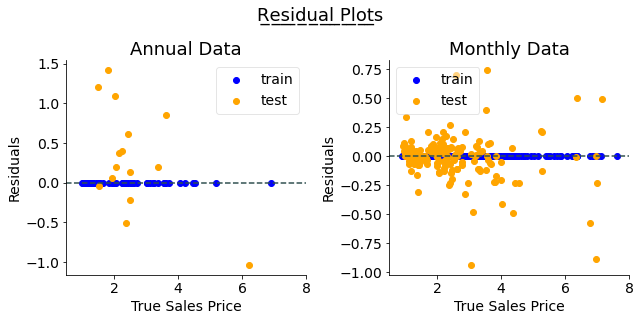

Model:  DecisionTreeRegressor 
Annual Train Data, p: 0.00e+00
Statistically different than the baseline.

Annual Test Data, p: 3.65e-01
Not statistically different from the baseline.

Monthly Train Data, p: 0.00e+00
Statistically different than the baseline.

Monthly Test Data, p: 0.00e+00
Statistically different than the baseline.



In [16]:
annual_tree, monthly_tree = model_fitter_plotter(DecisionTreeRegressor, random_state=1)

The decision tree model did not perform as well as the KNeighbors model for the annual data (R<sup>2</sup>=0.683 and 0.756 for the test data, respectively). However, this model did result in the best R<sup>2</sup> value for the monthly test data of any model so far (R<sup>2</sup>=0.980, compared to 0.773 for KNeighbors). Additionally, there doesn't appear to be any patterns in the residual plots, and I finally got a p-value lass than $ \alpha $=0.05 for the monthly data. This means the model is performing significantly better than the baseline for the monthly data. Very exciting! 

A nice thing about decision tree models is you can also look at the decision tree itself if you want to derive any additional insights. I will show the annual decision tree now for an example.

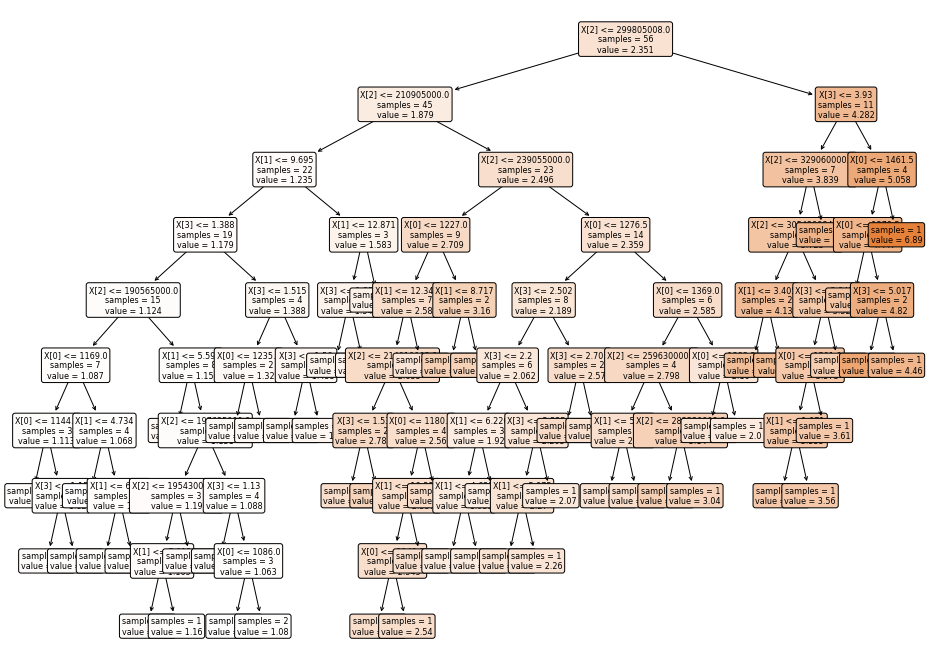

In [17]:
plt.figure(figsize=(16,12))
plot_tree(annual_tree,
          fontsize=8,
          rounded=True,
          impurity=False,
          filled=True)
plt.show()

Notice that in each box it lists the feature the decision is being made on, X[0], X[1], etc., with the number in brackets referring to the column number of the feature, followed by the criteria for that decision. In the second line is the number of observations or "samples" passing through the decision filter. And in the bottom of the decision description box is the value returned if that decision is reached.  

I will optimize this model for three parameters:
- `criterion`: `squared_error`, `friedman_mse`, and `absolute_error`. At each decision, one of these functions is used to measure the quality of the split. 
- `splitter`: `best` and `random`. This is the strategy the model uses for determining the best split.
- `max-depth`: this feature controls how many decisions may be made, which may be helpful for improving the model for the annual data.

### Random Forest Regression with RandomForestRegressor

Random forests are an abstracted step up from decision trees. They work by creating a specific number of new datasets from the training data and then running each of these new datasets through its own decision tree. By default, the model creates 100 trees, along with their corresponding datasets. The datasets are filled by randomly sampling the training data, meaning that any given observation may be used in any tree a number of times from 0 to the total number of observations in the training dataset. For predictions, the model takes in an observation and runs it through all of the decision trees, and the final answer is the average returned from all of the trees in the forest.  

Let's see how an un-optimized version of this model works on the data.

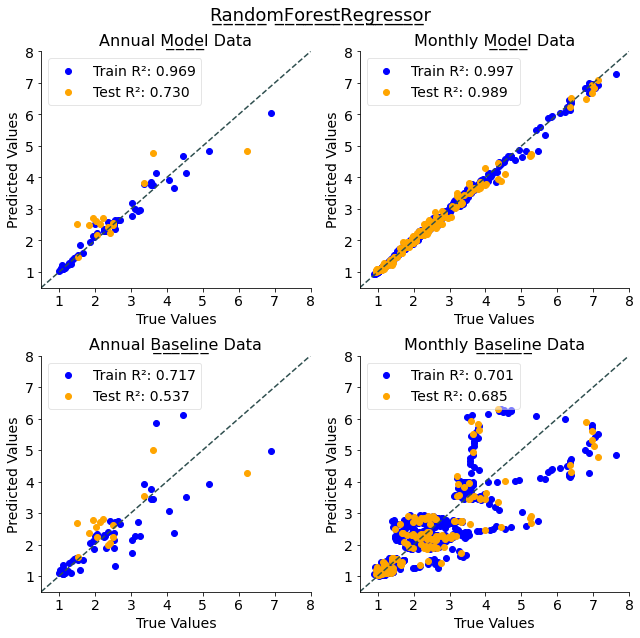

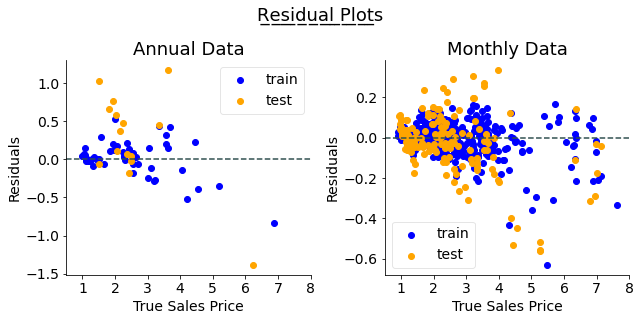

Model:  RandomForestRegressor 
Annual Train Data, p: 0.00e+00
Statistically different than the baseline.

Annual Test Data, p: 2.27e-01
Not statistically different from the baseline.

Monthly Train Data, p: 0.00e+00
Statistically different than the baseline.

Monthly Test Data, p: 0.00e+00
Statistically different than the baseline.



In [18]:
annual_forrest, monthly_forrest = model_fitter_plotter(RandomForestRegressor, random_state=1)

The results are similar to the decision tree results, but with slight improvements in the R<sup>2</sup> values. For example, the annual test data now has an R<sup>2</sup> value of 0.730, whereas with the decision tree it was 0.683. Thus, this random forest regression appears to be a very promising candidate model for the given problem.

Hyperparameters I will try to optimize for this model include:
- `n_estimators`: the number of decision trees to use.
- `criterion`: `squared_error`, `friedman_mse`, and `absolute_error`. At each decision, one of these functions is used to measure the quality of the split. 
- `max-depth`: this feature controls how many decisions may be made, which may be helpful for improving the model for the annual data.

### Support Vector Regression with SVR

Support vector machines are a popular machine learning classifier. In this model, multidimensional boundaries are drawn for separating features of various classes from one another. Support vector machines work similar in that multidimensional boundaries are drawn. However, in this case, the model tries to fit all of the data within the boundaries. A function is then used to try to fit the data within the margins. This is somewhat similar to how linear regression works, and in fact, if we use the `linear` kernel for our support vector regression, the results will look very similar to linear regression. The main difference is that in linear regression, outliers contribute less to the overall fit than data close to the best fit line, whereas in support vector regression, outliers have a stronger impact. Additionally, clusters of close data points are more prone to impact linear regression models than support vector regression models.  

There are 4 main kernel's that can be used for this model:
- `linear`: fits the data to a linear function.
- `poly`: fits the data to a polynomial. The degree of the polynomial can be set using the `degree` parameter.
- `rbf`: this is the radial basis function. It essentially works like a nearest neighbor function, except all of the points in the training data influence the predicted value and their influence is determined by an exponential scalar to their euclidean distance. 
- `sigmoid`: fits the data to a sigmoid function.

The `rbf` kernel tends to be the most powerful of these and is applicable to the widest range of problems, so let's see how an SVR model performs with an `rbf` kernel on the corn data.

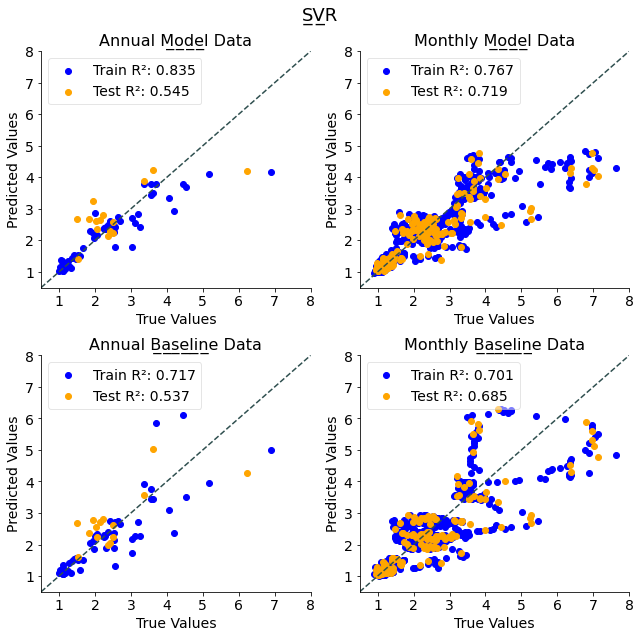

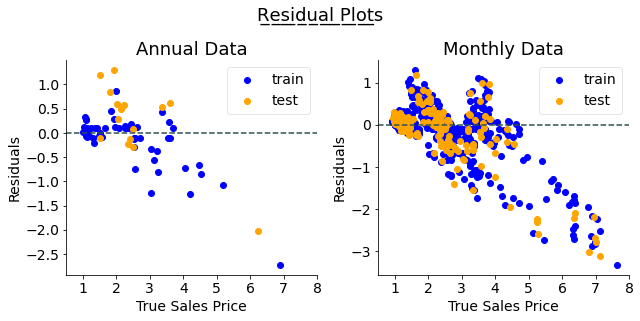

Model:  SVR 
Annual Train Data, p: 9.20e-02
Not statistically different from the baseline.

Annual Test Data, p: 4.02e-01
Not statistically different from the baseline.

Monthly Train Data, p: 0.00e+00
Statistically different than the baseline.

Monthly Test Data, p: 6.20e-02
Not statistically different from the baseline.



In [19]:
svr_annual, svr_monthly = model_fitter_plotter(SVR, scaler=StandardScaler, kernel='rbf')

This model resulted in R<sup>2</sup> values similar to those achieved using linear regression. For example, the annual test R<sup>2</sup> value obtained here was 0.545, and 0.549 was obtained using linear regression. There was a statistical difference in the quality of the fit for the monthly train data relative to the baseline, but the same can't be said for any of the test data modeled using support vector regression.  

Just for fun, I am going to run this model using the other kernels to see how the results look. I'm not expecting much improvement, so I will just print out the truncated report.  

I will start with the `linear` kernel.

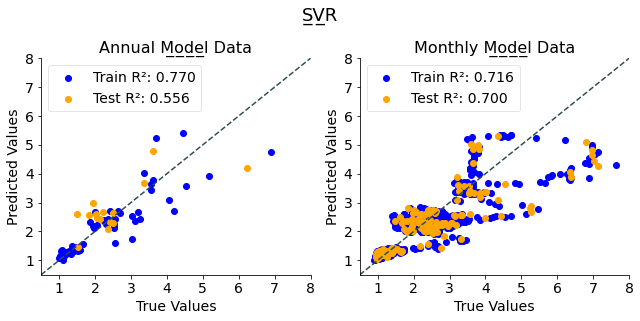

'end of truncated report'

In [20]:
model_fitter_plotter(SVR, scaler=StandardScaler, kernel='linear', full_report=False)

There actually is some slight improvement for the annual test data compared to the `rbf` kernel. Here, an R<sup>2</sup> value of 0.556 was obtained, whereas a value of 0.545 was obtained with `rbf`. However, the same can't be said for the monthly test data. Here, an R<sup>2</sup> value of 0.700 was obtained for the monthly test data, whereas a slightly higher value of 0.719 was obtained for the monthly test data using `rbf`. Overall, not really much of a change.
  
Next, I will try the `poly` kernel using the default of 3 dimensions.

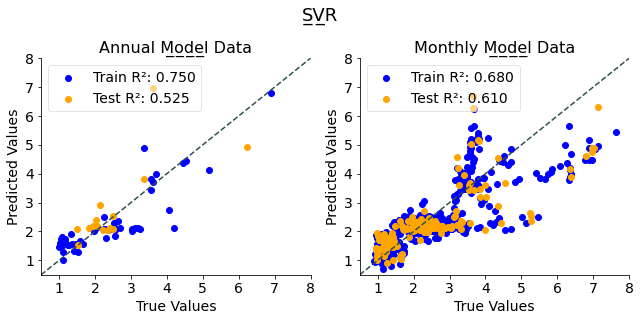

'end of truncated report'

In [21]:
model_fitter_plotter(SVR, scaler=StandardScaler, kernel='poly', full_report=False)

These R<sup>2</sup> values are all lower than those obtained using the `linear` and `rbf` kernels. So, no improvement.

Lastly, I will try the `sigmoid` kernel. None of the features included here displayed any sigmoidal tendencies, so the results from this model should be fun.

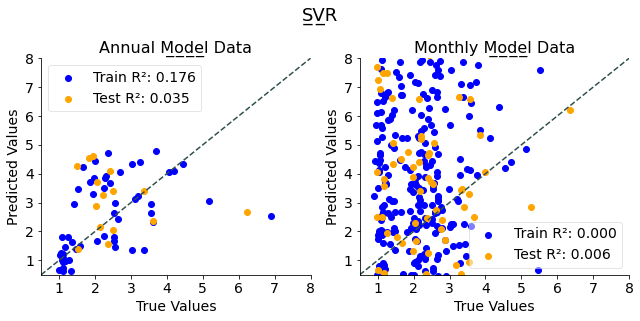

'end of truncated report'

In [22]:
model_fitter_plotter(SVR, scaler=StandardScaler, kernel='sigmoid', full_report=False)

That model was clearly not a good fit for this data, but I do find the plot of the monthly data visually pleasing.  

Support vector regression does not look promising enough to bother with further refinement.

### XGBoost Regression with XGBRegressor

Boosting is a technique where the model is created iteratively, and each knew iteration tries to correct the mistakes of the previous iteration. This can be done by simply focusing on incorrect predictions, such as in adaptive boosting techniques. However, in regression modeling, just about all of the predictions are wrong by some amount. Therefore, for regression, we need to use gradient boosting, wherein each knew iteration tries to minimize the residuals from the previous model.  

The boosting algorithm I will be using here is XGBoost, which stands for eXtreme Gradient Boosting. This method iterates over decision trees, trying to improve the tree after every run. Thus, this model is somewhat similar to random forest regression, except where random forests rely on statistical probabilities to cause the model to converge at the best answer, XGBoost actively tries to find the best answer.

I will now run the model with base parameters to see how it performs with the corn data.

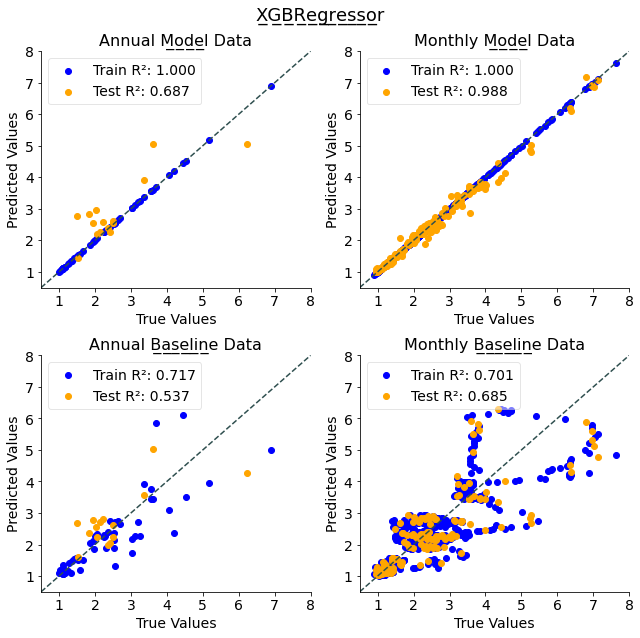

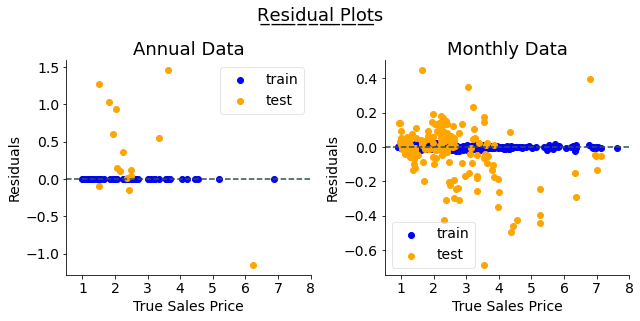

Model:  XGBRegressor 
Annual Train Data, p: 0.00e+00
Statistically different than the baseline.

Annual Test Data, p: 4.85e-01
Not statistically different from the baseline.

Monthly Train Data, p: 0.00e+00
Statistically different than the baseline.

Monthly Test Data, p: 0.00e+00
Statistically different than the baseline.



In [23]:
XGB_annual, XGB_monthly = model_fitter_plotter(XGBRegressor, random_state=1)

These results look great, especially for the monthly test data, where the XGBoost model resulted in an R<sup>2</sup> value of 0.988. This means that the model can account for all but 1.2% of the variability in that data. The only model that has performed better thus far is the random forest, which achieved a 0.989 r<sup>2</sup> value for the monthly test data. The XGBoost model still isn't giving me quite what I want for the annual test data. I have yet to improve the fit of that data with any statistical significance.

XGBRegressor has a number of hyperparameters to optimize. However, the ones I will focus on here are:
- `eta`: the model learning rate or step size used for moving between iterations. 
- `booster`: defines which booster to use for model boosting. Options to try will include `gbtree`, `gblinear`, and `dart`.
- `max_depth`: maximum depth per decision tree
- `min_child_weight`: if the minimum child weight is achieved, the tree will give up partitioning.
- `objective`: controls the learning task. Options to try will include `reg:squarederror`, `reg:gamma`, and `reg:tweedie`.

## Pipeline for Model Refinement

I have now tried a number of models and found a few with a lot of promise. Here, I am going to feed the promising models into a grid search, which will vary the parameters of all of the models for me and decide on the best model for me to use. More than likely a different model will result for the annual data than for the monthly data, as these data sets have different structures, features, and number of observations.  

The models and hyperparameters I will be optimizing on include:
- KNeighborsRegressor (using a StandardScaler)
    - n_neighbors
    - weights: uniform and distance
    - algorithm: ball_tree, kd_tree, and brute  
<br><br>
- DecisionTreeRegressor
    - criterion: squared_error, friedman_mse, and absolute_error
    - splitter: best and random
    - max_depth
<br><br>
- RandomForestRegressor
    - n_estimators
    - criterion: squared_error, friedman_mse, and absolute_error
    - max-depth
<br><br>
- XGBRegressor
    - eta
    - booster: gbtree, gblinear, and dart
    - max_depth
    - min_child_weight
    - objective: reg:squarederror, reg:gamma, and reg:tweedie.
    
I have selected a range of values for each hyperparameter, which will result in me testing 1,170 models per data set. Thank goodness I'm working with a pretty small data set.  

I will be using `GridSearchCV` for this, which has built in cross validation. In all of the models I have looked at so far I have been scoring the model on how good it does on the test data. However, this means that information about my test data is actually being leaked into my model. To get around this, cross validation essentially breaks the training data into different train / test sets. I will be using a cross validation of 3, meaning that the data will be used to generate three pairs of train / validation data. Cross validation makes a model more robust against future unknown data than simply selecting the model with the best score overall.  

The first thing I will need to do is setup my pipeline and grid search.

In [24]:
# Create an estimator, which is a list of tuples to feed to the pipeline.
estimators = [('normalise', StandardScaler()), ('model', KNeighborsRegressor())]

# Convert the estimators into a pipeline object for grid iteration.0
pipe = Pipeline(estimators)

# Create a list of dictionaries. The dictionaries contain the models to be tested and any hyperparameters to tune.
param_grid = [
            {'model': [KNeighborsRegressor()], 
             'normalise': [StandardScaler()],
             'model__n_neighbors': range(1,31),
             'model__weights': ['uniform', 'distance'],
             'model__algorithm': ['ball_tree', 'kd_tree', 'brute']
            },
            {'model': [DecisionTreeRegressor(random_state=1)],
             'normalise': [None], 
             'model__criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
             'model__splitter': ['best', 'random'],
             'model__max_depth': [None, 5, 10, 20, 30]
            },
            {'model': [RandomForestRegressor(random_state=1)],
             'normalise': [None],
             'model__n_estimators': [10, 50, 100, 200],
             'model__criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
             'model__max_depth': [None, 5, 10, 20, 30]
            },
            {'model': [XGBRegressor(verbosity=0, random_state=1)],
             'normalise': [None],
             'model__eta': [0.1, 0.2, 0.3, 0.4, 0.5],
             'model__booster': ['gbtree', 'gblinear', 'dart'],
             'model__max_depth': [2, 3, 4, 5, 6],
             'model__min_child_weight': [0, 0.5, 1, 2],
             'model__objective': ['reg:squarederror', 'reg:gamma', 'reg:tweedie']
            }
]

# Feed the pipeline object and grid parameters into GridSearchCV to create a grid search object. 
# 3 cross validations are used.
grid = GridSearchCV(pipe, param_grid, cv=3)

I will now feed the monthly data into the grid search and see what comes out the other side.

In [25]:
# Split the monthly data into train and test sets.
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    monthly_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
    monthly_df_model_ready['PRICE RECEIVED, MEASURED IN $ / BU'], 
    test_size=0.2,
    random_state=1
)

# Fit the grid search object with the monthly training data.
fittedgrid_monthly = grid.fit(X_train_monthly, y_train_monthly)

# Print out the best model found, along with the model's prediction score.
print('Best model: ')
print(fittedgrid_monthly.best_params_)
print('Best model score: ')
print(fittedgrid_monthly.score(X_test_monthly, y_test_monthly))

Best model: 
{'model': XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eta=0.4, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:tweedie', predictor=None, random_state=1,
             reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
             subsample=None, tree_method=None, validate_parameters=None,
             verbosity=0), 'model__booster': 'gbtree', 'model__eta': 0.4, 'model__max_depth': 5, 'model__min_child_weight': 2, 'model__objective': 'reg:tweedie', 'normalise': None}
Best model score: 
0.9855930131724879


It looks like the best model for the monthly data is an XGBRegressor model using the following parameters:
- `booster`: `gbtree`
- `eta`: 0.4
- `max_depth`: 5
- `min_child_weight`: 2
- `objective`: `reg:tweedie`

This model achieved a score of 0.986 for the monthly test data. While this is slightly less than the scores of 0.989 achieved with random forest and 0.988 achieved earlier with XGBoost, the model produced by the grid search has been cross validated. A cross validated model has a better chance of holding up against new data than a non-cross validated model with a slightly higher score.

In [26]:
# Split the annual data into train and test sets.
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(
    annual_df_model_ready.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
    annual_df_model_ready['PRICE RECEIVED, MEASURED IN $ / BU'], 
    test_size=0.2,
    random_state=1
)

# Fit the grid search object with the annual training data.
fittedgrid_annual = grid.fit(X_train_annual, y_train_annual)

# Print out the best model found, along with the model's prediction score.
print('Best model: ')
print(fittedgrid_annual.best_params_)

print('Best model score: ')
print(fittedgrid_annual.score(X_test_annual, y_test_annual))

Best model: 
{'model': XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eta=0.5, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0), 'model__booster': 'gbtree', 'model__eta': 0.5, 'model__max_depth': 5, 'model__min_child_weight': 2, 'model__objective': 'reg:squarederror', 'normalise': None}
Best model score: 
0.6814426886009207


The best model for the annual data is also an XGBoost model but with following hyperparameters:
- `booster`: `gbtree`
- `eta`: 0.5
- `max_depth`: 5
- `min_child_weight`: 2
- `objective`: `reg:reg:squarederror`

The score for this model, 0.681, is somewhat disappointing, especially since the KNeighbors model achieved a score of 0.756. Unfortunately, not even the KNeighbors model was statistically better than just using the baseline predictions. So, why was I able to model the monthly data so much better than the annual data? There could be several reasons for this. (1) Perhaps I just chose bad independent variables to model the annual sales price with. (2) Maybe there just wasn't enough annual sales data fed into the models to get a good prediction. (3) Maybe I over pruned the data. XGBoost and other decision tree regression models can actually stand a bit of multicolinearity.  

I am now going to try the same grid searches, but using the scrubbed data frames rather than the model ready data frames. The difference between these data is the scrubbed data still has more than a dozen features, whereas the model ready data has been filtered for multicolinearity. I will start with the annual data, since it has fewer observations and should run much faster.

In [8]:
# Import scrubbed data frames.
annual_scrubbed = pd.read_csv('./DataFrames/scrubbed_df_annual.csv', index_col=0)
monthly_scrubbed = pd.read_csv('./DataFrames/scrubbed_df_monthly.csv', index_col=0, infer_datetime_format=True)

# Confirm the data frames imported correctly.
display(annual_scrubbed, monthly_scrubbed)

,ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","PRICE RECEIVED, MEASURED IN $ / BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,GDP,GDP_PCH,Inflation Rate YOY,USPop,baseline
Year,,,,,,,,,,,,,,,,,
1950,72398000.0,2.764071e+09,1.52,4.222366e+09,38.2,1080,4712,30.87,1.93,51.39,63.61,39.17,299.82725,10.03834,0.059,152270000,1.520000
1951,71191000.0,2.628937e+09,1.66,4.364659e+09,36.9,1168,4744,31.25,1.65,51.12,63.19,39.04,346.91325,15.70438,0.060,154880000,1.520000
1952,71353000.0,2.980793e+09,1.52,4.557031e+09,41.8,1272,4587,26.34,-1.84,52.27,64.70,39.85,367.34075,5.88836,0.008,157550000,1.590000
1953,70738000.0,2.881801e+09,1.48,4.291366e+09,40.7,1276,4277,28.31,-1.76,53.37,65.76,40.96,389.21750,5.95544,0.007,160180000,1.566667
1954,68668000.0,2.707913e+09,1.43,3.872433e+09,39.4,1275,4425,26.15,-4.33,53.33,65.78,40.87,390.54900,0.34210,-0.007,163030000,1.553333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,86748000.0,1.514804e+10,3.36,5.130430e+10,174.6,1528,3921,31.42,-0.82,54.92,66.69,43.13,18695.10575,2.68638,0.021,322940000,3.923333
2017,83735781.0,1.469141e+10,3.36,4.956785e+10,176.6,1390,3876,32.31,0.89,54.55,66.35,42.74,19479.62250,4.19638,0.021,324990000,3.556667
2018,81276000.0,1.434037e+10,3.61,5.210240e+10,176.4,1547,4340,34.65,-1.80,53.52,65.09,41.94,20527.15875,5.37760,0.019,326690000,3.443333


,"PRICE RECEIVED, MEASURED IN $ / BU",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,USPop,Inflation Rate,GDP,GDP_PCH,baseline
1950-01-01,1.15,23,786,3.36,0.54,30.43,41.32,19.56,1.498775e+08,0.004917,91.486000,1.256463,1.150000
1950-02-01,1.16,11,731,2.23,0.70,35.55,47.10,24.01,1.500950e+08,0.004917,92.547667,1.256463,1.150000
1950-03-01,1.19,12,710,2.49,0.81,38.84,50.52,27.16,1.503125e+08,0.004917,93.609333,1.256463,1.150000
1950-04-01,1.26,21,428,2.08,0.64,48.65,61.18,36.12,1.505300e+08,0.004917,94.671000,1.134147,1.150000
1950-05-01,1.34,106,177,2.88,0.67,59.45,72.27,46.63,1.507475e+08,0.004917,95.732667,1.134147,1.155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,3.12,351,7,2.43,-0.83,74.70,87.84,61.54,3.293333e+08,0.001000,6861.621333,2.842827,3.541667
2020-09-01,3.41,174,59,2.44,-0.95,65.91,78.80,52.99,3.294700e+08,0.001000,7046.191333,2.842827,3.534167
2020-10-01,3.61,77,252,2.18,-0.84,54.28,66.97,41.59,3.296067e+08,0.001000,7083.860556,0.534603,3.526389
2020-11-01,3.79,28,428,1.94,-1.52,46.31,58.32,34.32,3.297433e+08,0.001000,7121.529778,0.534603,3.522222


In [9]:
# Split the annual data into train and test sets.
X_train_annual_scrubbed, X_test_annual_scrubbed, y_train_annual_scrubbed, y_test_annual_scrubbed = train_test_split(
    annual_scrubbed.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
    annual_scrubbed['PRICE RECEIVED, MEASURED IN $ / BU'], 
    test_size=0.2,
    random_state=1
)

# Fit the grid search object with the annual training data.
fittedgrid_annual_scrubbed = grid.fit(X_train_annual_scrubbed, y_train_annual_scrubbed)

# Print out the best model found, along with the model's prediction score.
print('Best model: ')
print(fittedgrid_annual_scrubbed.best_params_)

print('Best model score: ')
print(fittedgrid_annual_scrubbed.score(X_test_annual_scrubbed, y_test_annual_scrubbed))

NameError: name 'grid' is not defined

Wow! A model score of 0.950 was obtained using an XGBoost model. That is incredible and certainly a statistical improvement over the baseline predictions. This is the first model of the annual data that has been produced with a score above 0.8, let alone above 0.9. The parameters of this model are as follows:
- `booster`: `gblinear`
- `eta`: 0.5
- `max_depth`: 3
- `min_child_weight`: 0
- `objective`: `reg:squarederror`

I could still try removing features from the scrubbed data to see if I can get the score a little higher, but a model score of 0.95 is really good and I'm pretty happy with it.

I will now try running the scrubbed monthly data to see if I can beet the already high score of 0.985 obtained with the model ready data. However, since I already have a great model for this data and to speed up analysis, I will restrict the search to only look at XGBoost models, as those have now given such strong performance.

In [29]:
param_grid_XG_only = [
            {'model': [XGBRegressor(verbosity=0, random_state=1)],
             'normalise': [None],
             'model__eta': [0.1, 0.2, 0.3, 0.4, 0.5],
             'model__booster': ['gbtree', 'gblinear', 'dart'],
             'model__max_depth': [2, 3, 4, 5, 6],
             'model__min_child_weight': [0, 0.5, 1, 2],
             'model__objective': ['reg:squarederror', 'reg:gamma', 'reg:tweedie']
            }
]

# Feed the pipeline object and grid parameters into GridSearchCV to create a grid search object. 
# 3 cross validations are used.
grid_XG_only = GridSearchCV(pipe, param_grid_XG_only, cv=3)

# Split the annual data into train and test sets.
X_train_monthly_scrubbed, X_test_monthly_scrubbed, y_train_monthly_scrubbed, y_test_monthly_scrubbed = train_test_split(
    monthly_scrubbed.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
    monthly_scrubbed['PRICE RECEIVED, MEASURED IN $ / BU'], 
    test_size=0.2,
    random_state=1
)

# Fit the grid search object with the annual training data.
fittedgrid_monthly_scrubbed = grid_XG_only.fit(X_train_monthly_scrubbed, y_train_monthly_scrubbed)

# Print out the best model found, along with the model's prediction score.
print('Best model: ')
print(fittedgrid_monthly_scrubbed.best_params_)

print('Best model score: ')
print(fittedgrid_monthly_scrubbed.score(X_test_monthly_scrubbed, y_test_monthly_scrubbed))

Best model: 
{'model': XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eta=0.3, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:gamma', predictor=None, random_state=1,
             reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
             subsample=None, tree_method=None, validate_parameters=None,
             verbosity=0), 'model__booster': 'dart', 'model__eta': 0.3, 'model__max_depth': 5, 'model__min_child_weight': 2, 'model__objective': 'reg:gamma', 'normalise': None}
Best model score: 
0.9854066336407971


For the scrubbed monthly data, the grid search returned a model with a score of 0.9854, which is just slightly lower than the score of 0.9856 I got with the model ready data. Thus, I don't need as many features to model the monthly sales price as I do to model annual sales prices.

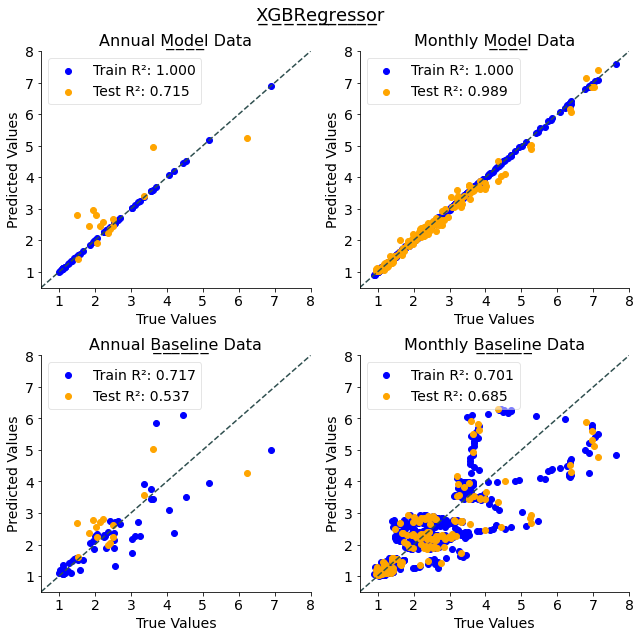

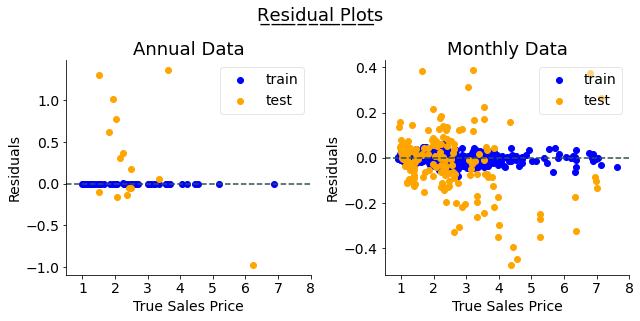

Model:  XGBRegressor 
Annual Train Data, p: 0.00e+00
Statistically different than the baseline.

Annual Test Data, p: 4.96e-01
Not statistically different from the baseline.

Monthly Train Data, p: 0.00e+00
Statistically different than the baseline.

Monthly Test Data, p: 0.00e+00
Statistically different than the baseline.



In [6]:
XGB_annual, XGB_monthly = model_fitter_plotter(XGBRegressor, random_state=1, booster='dart', eta=0.3, max_depth=5, min_child_weight=2, objective='reg:squarederror')

## Neural Networks

The last type of model I will explore here is the neural network. The neural network got its name from the way the structure of the network seems to look similar to a human neuron, or nerve cell. In a neural network, the features are passed into a set of nodes in what is called a hidden layer. In each of these nodes, the data is modeled and or transformed, depending on the activation function used in the node. If a second set of transformations is required, the hidden layer can then pass its results onto a second hidden layer, and so on and so forth. As a former biochemist, I can tell you confidently that neural networks and human neurons work and behave quite differently. But that's okay. Neural networks are still powerful, and the name is catchy.  

To construct my networks, I will be using tensorflow's keras package. Alternatively, I could have used sklearn's MLPRegressor package to make the same or similar neural networks. MLPRegressor is both faster and more memory efficient than tensorflow. (It also takes up less space in storage). The drawbacks to MLPRegressor, though, are that it can't yet be used for non-tabular data, such as images or audio files. Additionally, keras allows the user to build each layer of nodes manually, allowing for different layers to use different activation functions or even different number of nodes in different layers. Thus, keras is easier to use to build deep neural networks, and the code is a little easier to read, as you can just see line by line what is going into the network. Tensorflow is also built to work across a distributed network and is thus generally more applicable to the analysis of large data sets.

I'm not going to make too fancy of a neural network. I am here primarily going to play with the number of hidden layers and the number of nodes in the layers. Since this is a regression problem, I will be using the `relu` activator, with no activation function on the output layer. I could also use the `Linear` activator, but as all of the sales prices are positive numbers, `relu` and `linear` will both act the same.  

To expedite the construction and analyses of these networks, I will build another helper function. This one will take three main arguments: the number of hidden layers to use, the number of nodes in each layer, and the dataframe to analyze. Then, it will print out plots of the loss function and R<sup>2</sup> values for the train and test data as a function of the number of epochs used.

In [30]:
# Define the helper function.
def network_builder_testor(num_layers=2, nodes=40, epochs=range(1,51), df=annual_df_model_ready):
    """
    This function builds a neural network for analyzing regression data. The number of hidden layers and the 
    number of nodes in each layer can be set by the user. Note that all hidden layers will have the same number
    of nodes. I could fix this by allowing the function to accept a list for the number of nodes, but there is
    no need to get that complicated in the present excersize.
    
    Args:
        num_layers (int, optional): sets the number of hidden layers in the neural network. Default=2
        nodes (int, optional): sets the number of nodes in each hidden layer. Default=40
        epochs (list_like, optional): sets the range of epochs to test. The model is built iteratively so that
            the true number of epochs used is equal to the some of epochs (i.e. if epochs = 3, the true number of 
            epochs = 1 + 2 + 3). Default=range(1,51)
        df (pandas.dataframe, optional): the dataframe to be analyzed. Default=annual_df_model_ready
    
    Returns:
        None
    """
    
    # Split the dataframe into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns='PRICE RECEIVED, MEASURED IN $ / BU'), 
        df['PRICE RECEIVED, MEASURED IN $ / BU'], 
        test_size=0.2, random_state=1)
    
    # Scale the data using the standard scaler.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Create empty lists for storing the R2 and loss values for the train and test data.
    test_rs = []
    train_rs = []
    train_losses = []
    test_losses = []
    true_epochs = np.cumsum(epochs)

    # Instantiate a new keras model.
    model = keras.Sequential()
    
    # Set the random seed of the model so that results are consistent run to run.
    tf.random.set_seed(1)
    
    # Iterate through the number of layers provided, adding that number of hidden layers.
    # Each hidden layer is created with the user defined number of nodes.
    if num_layers:
        for num in range(num_layers):
            # Declare the hidden layers
            model.add(layers.Dense(nodes, activation="relu"))
    
    # Add the output layer.
    model.add(layers.Dense(1))

    # Compile the model using the Adam optimizer and mean squared error as the loss function.
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanSquaredError()
    )
    
    # Iterate through the iterator of epochs.
    for i in epochs:
        # Fit the neural network using i epochs.
        history = model.fit(X_train, y_train, epochs=i, verbose=0)

        # Extract the loss function score for the train and test data.
        train_loss = history.history["loss"][-1]
        test_loss = model.evaluate(X_test, y_test, verbose=0)

        # Add the loss values to the appropriate lists.
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Make predictions using the model for the train and test data.
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Score the model and add the scores to the appropriate lists.
        test_rs.append(r2_score(y_test,y_pred_test))
        train_rs.append(r2_score(y_train,y_pred_train))
        
        # Print the number of epochs completed so the user can monitor progress.
        print(f"epochs completed: {true_epochs[i-1]}", end='\r')

    # Generate plots of loss and R2 versus number of epochs used.
    plt.subplots(2, figsize=(8,4))
    for i in [1,2]:
        plt.subplot(1,2,i)
        plt.plot(true_epochs, train_losses if i == 1 else train_rs, color='blue', label='train')
        plt.plot(true_epochs, test_losses if i == 1 else test_rs, color='orange', label='test')
        plt.title('Loss vs epochs' if i == 1 else 'R\u00b2 vs epochs', size=16)
        plt.xlabel('epochs', size=14)
        plt.ylabel('Loss' if i == 1 else 'R2', size=14)
        plt.ylim([0,1])
        plt.legend(fontsize=14)
    
    plt.suptitle(f'Neural Network with {num_layers} layers and {nodes} nodes\n({"annual" if len(df) == 71 else "monthly"})', size=18)
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    print(f"max test R\u00b2: {round(max(test_rs), 3)}, obtained with {true_epochs[test_rs.index(max(test_rs))]} epochs\n")
    
    return None

Now that the function is built, I will try using the default number of layers and nodes to build networks for the annual and monthly data.

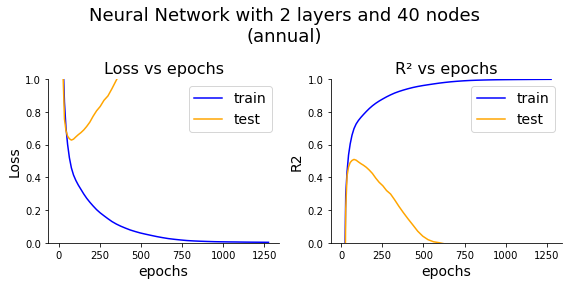

max test R²: 0.509, obtained with 78 epochs



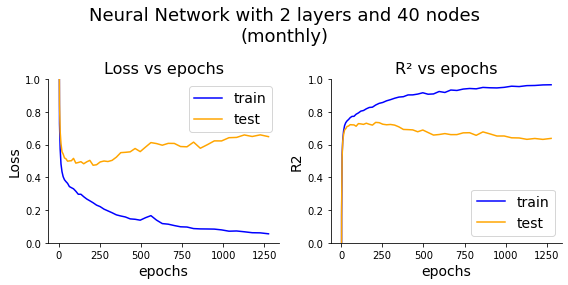

max test R²: 0.735, obtained with 210 epochs



In [31]:
network_builder_testor()
network_builder_testor(df=monthly_df_model_ready)

The default settings seem to have worked a bit better for the monthly data than for the annual data. The training of the network was going well for the annual data up until about 78 epochs. After that, the loss for the testing data began to increase rather than decrease, and a maximum R<sup>2</sup> value of about 0.509 was reached. A different story is seen for the training data. The loss function continued to fall, reaching approximately zero after about 1000 epochs. Clearly, what happened here is that after 78 epochs, the network began over fitting the training data. Thus, the predictions suffered.

The monthly data also appears to be over fitting after about 200 epochs, but the drop in R<sup>2</sup> isn't as pronounced as with the annual data. Additionally, a higher R<sup>2</sup> value of a little over 0.7 is achieved for the monthly test data, which is much better than that obtained for the annual test data.  

It is possible that the neural networks will also work better with the scrubbed data rather than the model ready data, as the XGBoost model did for the annual model. For comparison, I will rerun the model ready data along side the scrubbed data for the annual data set so I can see a side by side comparison.

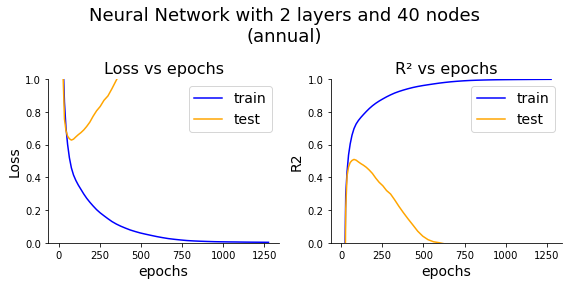

max test R²: 0.509, obtained with 78 epochs



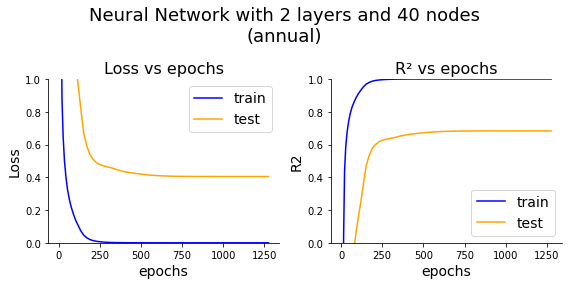

max test R²: 0.683, obtained with 1275 epochs



In [32]:
network_builder_testor()
network_builder_testor(df=annual_scrubbed)

The results for the model ready data are on top, and the results for the scrubbed data are on the bottom. Clearly, the network trained with the scrubbed data did much better. The loss and R<sup>2</sup> values leveled out after a few hundred epochs and never dipped back down. Additionally, an R<sup>2</sup> value of 0.683 was obtained for the test data with the scrubbed dataframe, whereas for the model ready data, the R<sup>2</sup> value never broke 0.6.  

The default for my network building function is to add two layers. But regression models often work best with only a single hidden layer. This is in contrast to image or audio processing networks, which often require the data to pass through multiple transformation layers for an accurate model to be built. So, I will now try building a neural network for the annual data with only a single hidden layer.

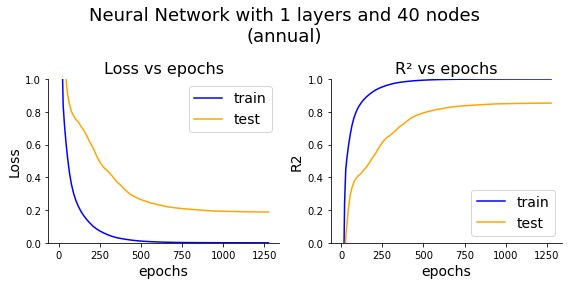

max test R²: 0.853, obtained with 1275 epochs



In [33]:
network_builder_testor(num_layers=1, df=annual_scrubbed)

Excellent! The R<sup>2</sup> value has increased to just over 0.85. I will now try optimizing for the number of nodes.

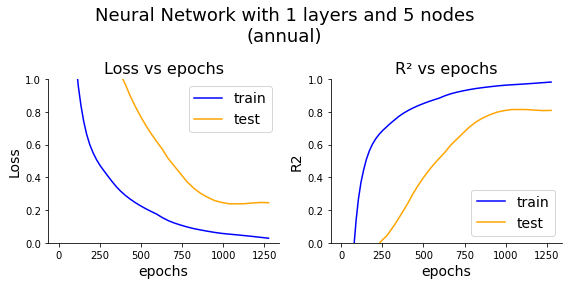

max test R²: 0.814, obtained with 1081 epochs



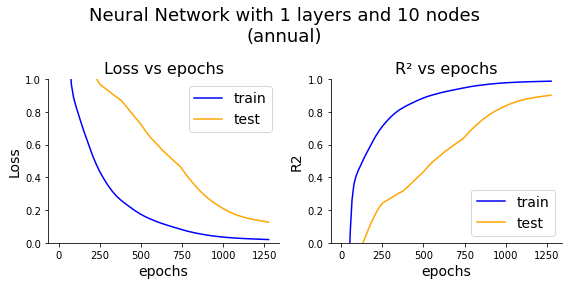

max test R²: 0.901, obtained with 1275 epochs



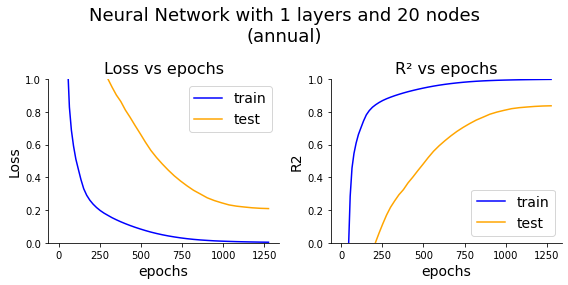

max test R²: 0.836, obtained with 1275 epochs



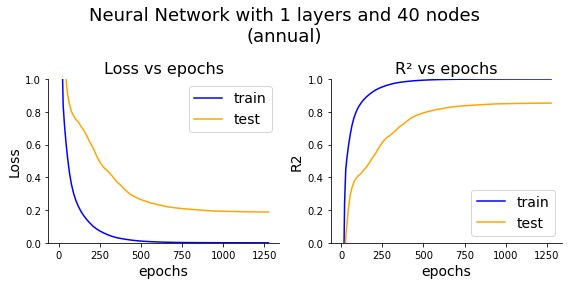

max test R²: 0.853, obtained with 1275 epochs



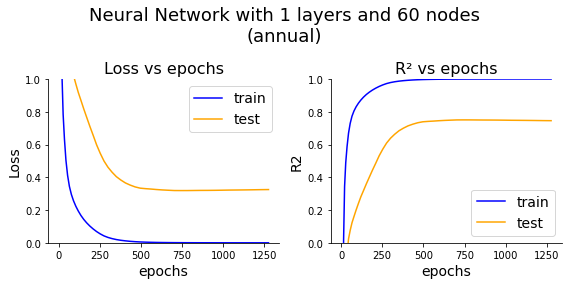

max test R²: 0.75, obtained with 741 epochs



In [34]:
network_builder_testor(num_layers=1, nodes=5, df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=10, df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=20, df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=40, df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=60, df=annual_scrubbed)

It looks like the best number of nodes is around 10. I will try to get that a little more precise with the best number of nodes to use. I will also try increasing the number of epochs to see how high I can get that R<sup>2</sup> value.

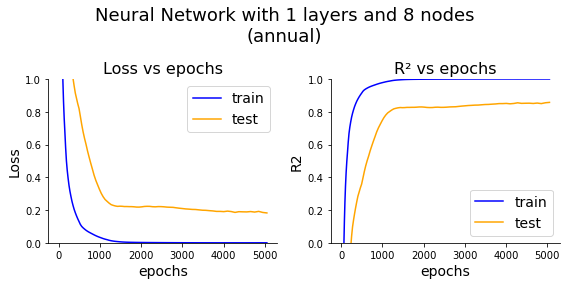

max test R²: 0.857, obtained with 5050 epochs



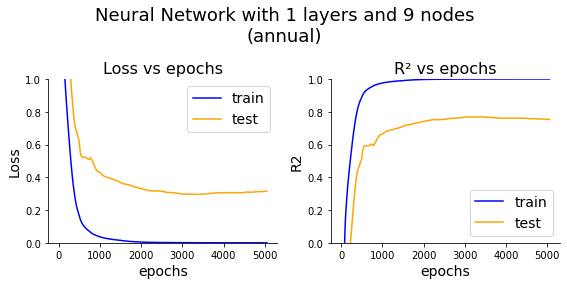

max test R²: 0.769, obtained with 3403 epochs



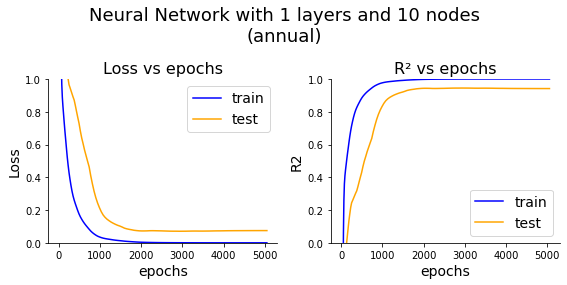

max test R²: 0.945, obtained with 2926 epochs



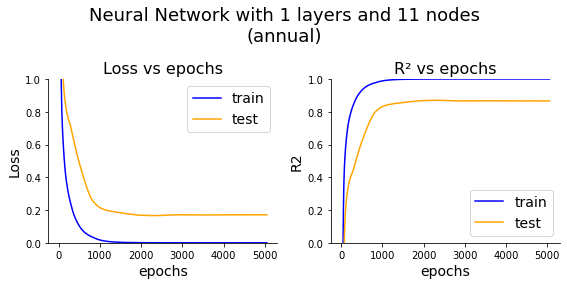

max test R²: 0.87, obtained with 2278 epochs



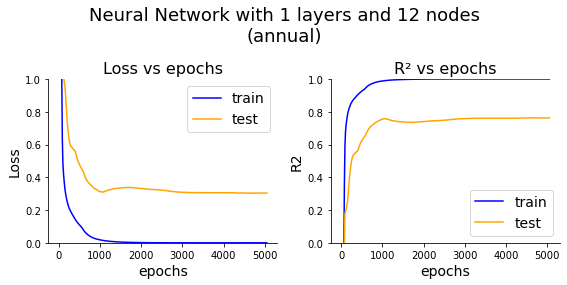

max test R²: 0.763, obtained with 4656 epochs



In [35]:
network_builder_testor(num_layers=1, nodes=8, epochs=range(1,101), df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=9, epochs=range(1,101), df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=10, epochs=range(1,101), df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=11, epochs=range(1,101), df=annual_scrubbed)
network_builder_testor(num_layers=1, nodes=12, epochs=range(1,101), df=annual_scrubbed)

It looks like the best results are still obtained with 10 nodes, for which an R<sup>2</sup> value of 0.945 is obtained with 2,926 epochs. This is close to the 0.950 score obtained with the XGBoost model. I could likely refine the model a little further, but I am satisfied with these results for now.  

I will now go through a similar set of procedures for the monthly data. I will use a single hidden layer and try to optimize the number of nodes and epochs.

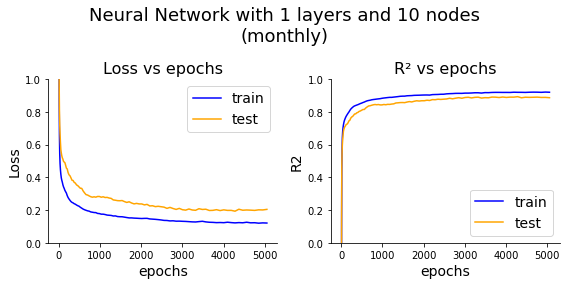

max test R²: 0.892, obtained with 4278 epochs



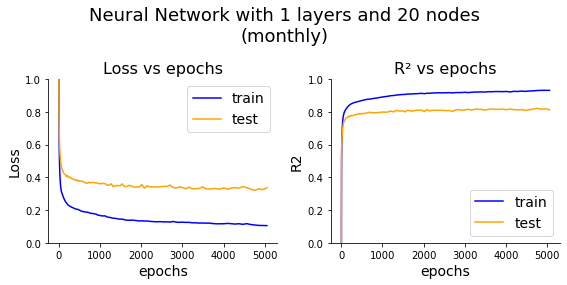

max test R²: 0.821, obtained with 4753 epochs



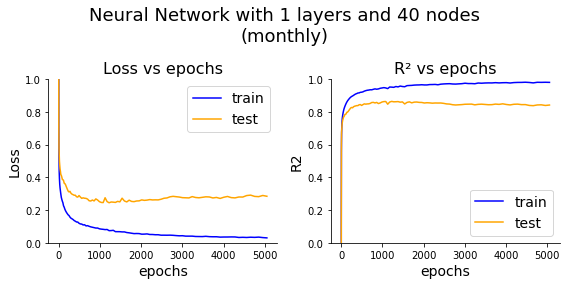

max test R²: 0.863, obtained with 1225 epochs



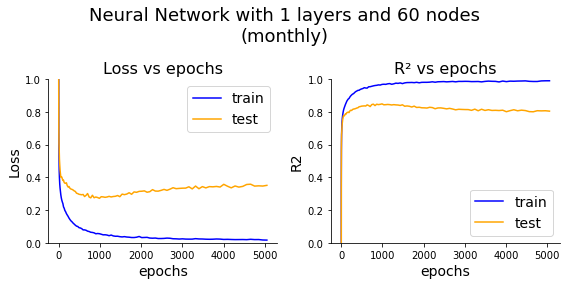

max test R²: 0.848, obtained with 990 epochs



In [36]:
network_builder_testor(num_layers=1, nodes=10, epochs=range(1,101), df=monthly_scrubbed)
network_builder_testor(num_layers=1, nodes=20, epochs=range(1,101), df=monthly_scrubbed)
network_builder_testor(num_layers=1, nodes=40, epochs=range(1,101), df=monthly_scrubbed)
network_builder_testor(num_layers=1, nodes=60, epochs=range(1,101), df=monthly_scrubbed)

Interesting. When more than about 20 nodes are used, the model begins over fitting after about 1000 epochs. This can be seen in both the rise in the loss and drop in R<sup>2</sup> values for the test data after about 1000 epochs. The best result was obtained with 10 nodes, wherein a score of 0.892 was obtained. This is significantly lower than the 0.986 score obtained with XGBoost. Therefore, I will stop trying to improve this model.

## Conclusions

Models for predicting both annual and monthly average sales prices per bushel of grain corn (`PRICE RECEIVED, MEASURED IN $ / BU`) have been successfully created.  

A model with a target training score of 0.950 was obtained for the <u>annual</u> data. This was an XGBRegressor model that was cross validated 3 times and built with the following hyperparameters:
- `booster`: `gbtree`
- `eta`: 0.5
- `max_depth`: 5
- `min_child_weight`: 2
- `objective`: `reg:squarederror`

This model was trained using the following features:
- `ACRES HARVESTED`: total acres of corn harvested in a given year.
- `PRODUCTION, MEASURED IN BU`: total number of bushels produced in a given year.
- `PRODUCTION, MEASURED IN $`: total revenue from sales of grain corn in a given year.
- `YIELD, MEASURED IN BU / ACRE`: average number of bushels produced from each acre of corn harvested.
- `Cooling Degree Days`: days where the average temperature is above room temperature.
- `Heating Degree Days`: days where the average temperature is below room temperature.
- `Precipitation`: total rainfall in inches, averaged across all 50 states for a given year.
- `Palmer Drought Severity Index (PDSI)`: a measure of relative dryness.
- `Average Temperature`: average temperature across all 50 states.
- `Maximum Temperature`: average of the maximum temperature for all 50 states.
- `Minimum Temperature`: average of the minimum temperature for all 50 states.
- `GDP`: US gross domestic product for the given year.
- `GDP_PCH`: change in US GDP versus the previous year.
- `Inflation Rate YOY`: inflation rate of the US dollar.
- `USPop`: total US population in the given year.
- `baseline`: the average price received over the past 3 years.
<br><br>  

For the <u>monthly</u> data, a model with a test score of 0.986 was obtained, also using XGBRegressor. This model was also cross validated 3 times and was built using the following hyperparameters:
- `booster`: `gbtree`
- `eta`: 0.4
- `max_depth`: 5
- `min_child_weight`: 2
- `objective`: `reg:tweedie`

The model was trained on the following features:  
- `Precipitation`: total rainfall in inches, averaged across all 50 states for the given month.
- `Cooling Degree Days`: a measure of how many degrees and how many days the temperature is above room temperature.
- `USPop`: total US population in a given month (modeled from yearly US population).
- `GDP_PCH`: change in US GDP for each month (calculated by dividing the quarterly GDP_PCH by three).
- `baseline`: the price received the previous month.